# Usability Improvements Engagement Analysis

**Megan Neisler, Senior Data Scientist, Wikimedia Foundation**

**12 April 2023**

[Task](https://phabricator.wikimedia.org/T302359)| [Codebase](https://gitlab.wikimedia.org/mneisler/usability-improvements-desktop-analysis-2023)

# Contents

1. [Purpose](#Purpose)
2. [Methodology](#Methodology)
3. [Edit Revert Rate](#Edit-Revert-Rate)
4. [Edit Completion Rate](#Edit-Completion-Rate)
5. [Edit Block Rate](#Edit-Block-Rate)
6. [User Block Rate](#User-Block-Rate)
7. [Opt Out Rate](#Opt-Out-Rate)


# Purpose

The suite of Usability Improvements (Topic Containers, Clear Affordances, and Page Frames) was made available by default at three partner wikis, ar.wiki, cs.wiki, and hu.wiki for both logged-in and logged-out users
This task involves the work of analyzing what impact this change is having on how people, across experience levels, use talk pages at these wikis.

This analysis focuses on if the new features are negatively impacting other peoples' experiences using Wikipedia talk pages. Specifically, we reviewed the revert rate, edit completion rates by interface, blocks and opt-out rate by users at the wikis where this was deployed. Additional metrics identifed to understand impacts on peoples' behavior will be addressed in the AB test.


# Methodology

To assess impact, we reviewed changes in identifed metrics two weeks pre and post deployment. 

**cswiki and huwiki:**
* Deployment date: 15 March 2023
* Two weeks Pre Deployment: 28 February 2023 - 14 March 2023
* Two weeks Post Deplyment: 15 March 2023 - 29 March 2023

**arwiki:** 
* Deployment date: 20 March 2023
* Two weeks Pre Deployment: 05 March 2023 - 19 March 2023
* Two weeks Post Deplyment: 20 March 2023 - 3 April 2023

Reviewed data was limited to any desktop edit on a talk page at the participating Wikipedias.
Note: Since this is a pre and post-deployment analysis (and not an AB test), there may be other factors such as seasonal trends that may have impacted these results. For this analysis, we are primarily looking to identify any significant increases or decreases in the identified metrics. 


Relevant phab tasks:
https://phabricator.wikimedia.org/T329407

In [276]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse)
    # Tables:
    library(gt)
    library(gtsummary)
})

In [277]:
options(repr.plot.width = 15, repr.plot.height = 10)
library(dplyr, warn.conflicts = FALSE)

# Suppress summarise info
options(dplyr.summarise.inform = FALSE)

# Edit Revert Rate

Defined as the proportion of all published edits that are reverted within 48 hours. 

Note: Currently don't have revert data for the first three days in April. Won't be able to update until snapshot is ready; however, there is sufficient data to identify any signficant changes to revert rate.


In [278]:
revert_data <-
  read.csv(
    file = 'Data/revert_data.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) # loads all revert data

In [279]:
#reformat and clean data
revert_data$date <- as.Date(revert_data$date, format = "%Y-%m-%d")

In [280]:
#clarfiy levels and labels for factor variables

revert_data$is_reverted <-
  factor(revert_data$is_reverted,
         levels = c("reverted", "not-reverted"),
         labels = c("Reverted", "Not reverted"))

#reformat user-id and adjust to include wiki to account for duplicate user id instances.
# Users do not have the smae user_id on different wikis
revert_data$user_id <-
  as.character(paste(revert_data$user_id,revert_data$wiki,sep ="-" ))

#clarfiy wiki names
revert_data <- revert_data %>%
 mutate(
    wiki = case_when(
      #clarfiy participating project names
      wiki == 'ptwiki' ~ "Portuguese Wikipedia",
      wiki == 'fawiki' ~ "Persian Wikipedia",
      wiki == 'trwiki' ~ "Turkish Wikipedia", 
      wiki == 'idwiki' ~ "Indonesian Wikipedia", 
      wiki == 'hiwiki' ~ "Hindi Wikipedia", 
      wiki == 'nlwiki' ~ "Dutch Wikipedia",  
      wiki == 'ukwiki' ~ "Ukrainian Wikipedia",
      wiki == 'thwiki' ~ "Thai Wikipedia", 
      wiki == 'azwiki' ~ "Azerbaijani Wikipedia", 
      wiki == 'rowiki' ~ "Romanian Wikipedia", 
      wiki == 'bnwiki' ~ "Bangia Wikipedia", 
      wiki == 'hewiki' ~ "Hebrew Wikipedia", 
    wiki == 'hewiki' ~ "Hebrew Wikipedia", 
     
    )
  ) 

# group user edit count 
revert_data <- revert_data %>%
 mutate(
    initial_edit_count = case_when(
      initial_edit_count  < 100  ~ "under 100",
      initial_edit_count  >= 100 ~ '100+ edits'  
    )
  ) 

# add factor levels to exp level
revert_data$initial_edit_count <-
  factor(revert_data$initial_edit_count,
         levels = c("under 100", "100+ edits"))

# fix inteface field to include
revert_data  <- revert_data%>%
  mutate(
    editor_interface = case_when (#clarfiy interface which matches mediawiki_editattempt_block schema
        integration=='discussiontools'  ~ 'discussiontools' ,
        integration=='page' & interface=='wikitext' ~ 'wikieditor' ,
        integration=='page' & interface=='visualeditor'  ~ 'visualeditor' ,
        integration=='page' & interface=='wikitext-2017'  ~ 'visualeditor',
        TRUE ~ 'Unknown' )
 )



## Daily Revert Rate

In [281]:
revert_rate_overall_daily <- revert_data %>%
    group_by(wiki, date) %>%
  summarise(n_edits = n_distinct(edit_save_id),
            n_reverts = n_distinct(edit_save_id[is_reverted == 'Reverted']),
           revert_rate = n_reverts/n_edits)


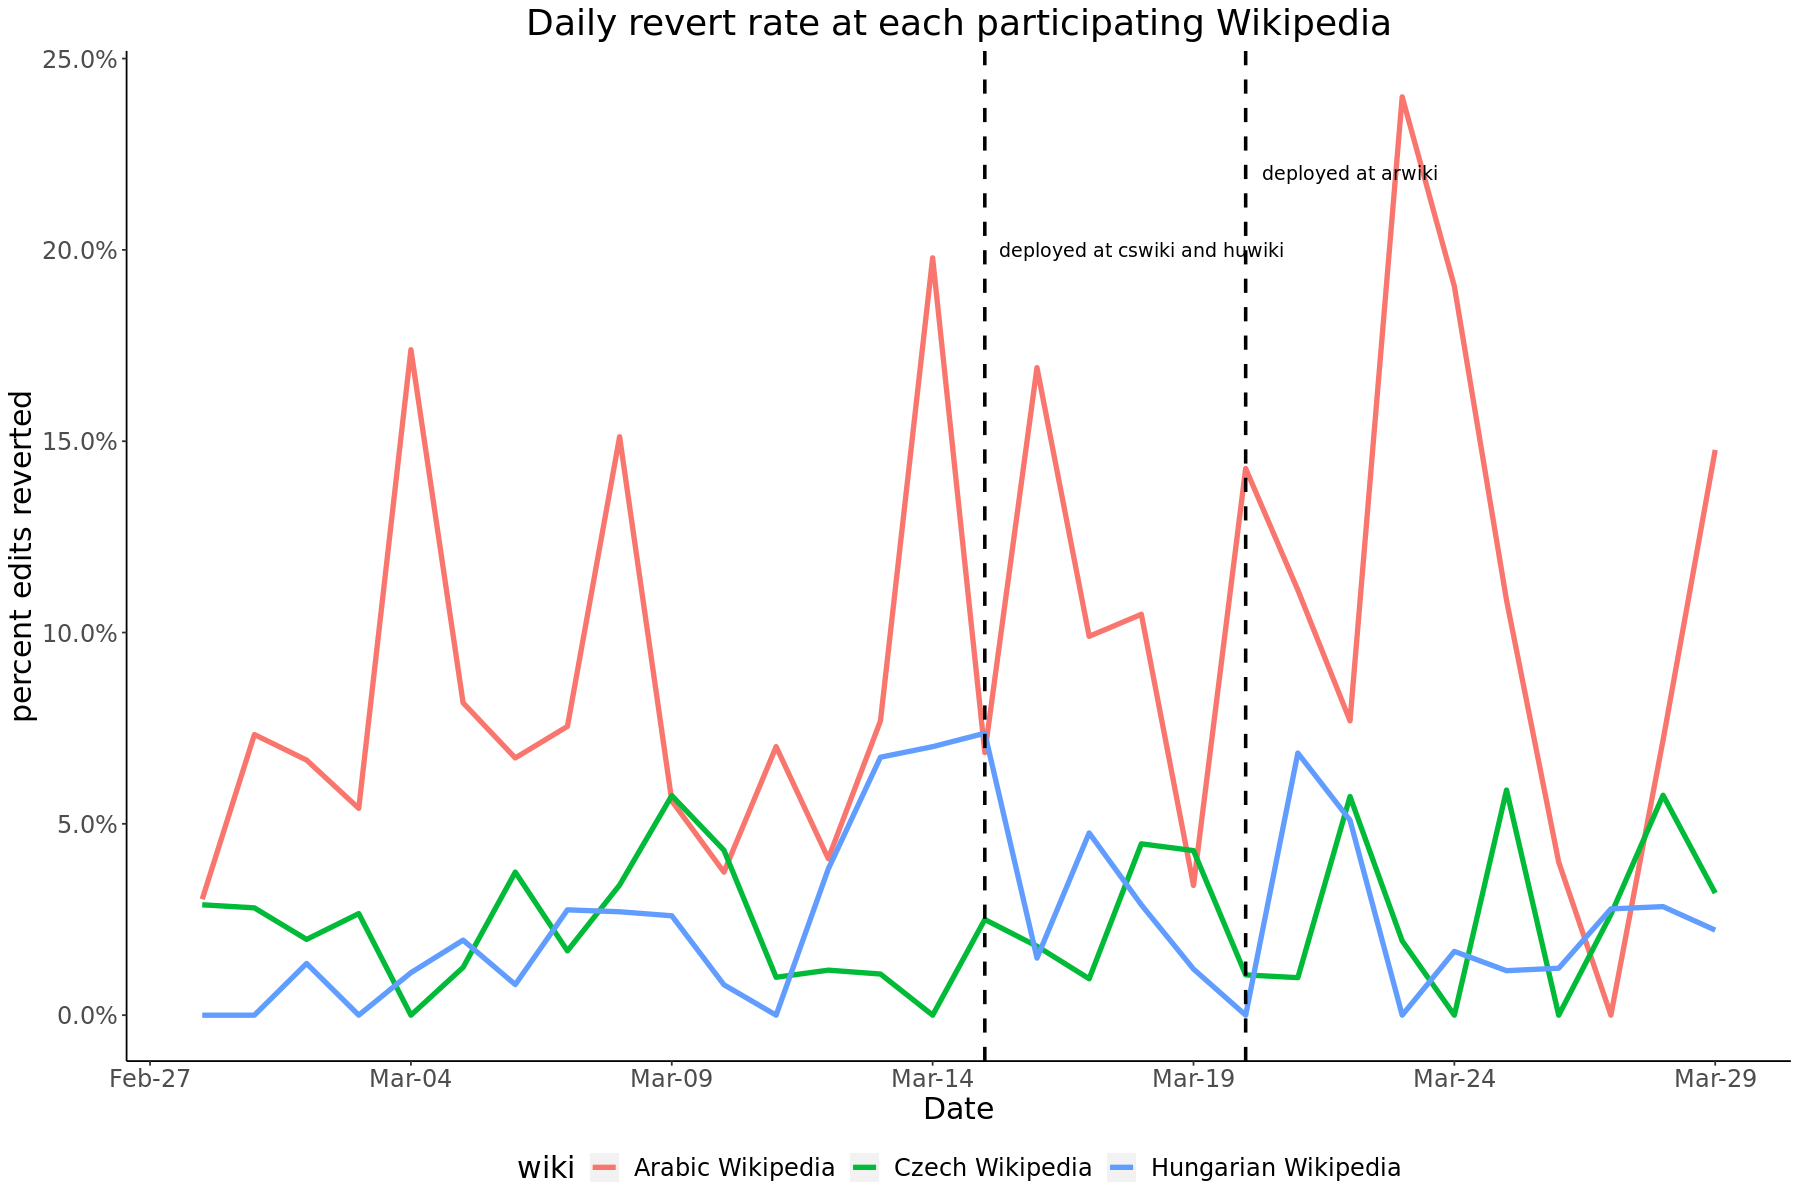

In [282]:
# plot daily session length before and after deployment of English Wikipedia

textaes <- data.frame(y = c(0.20, 0.22),
                      x = as.Date(c('2023-03-18','2023-03-22')),
                      lab = c('deployed at cswiki and huwiki', 'deployed at arwiki' ))

p <- revert_rate_overall_daily %>%
    ggplot(aes(x= date, y = revert_rate, color = wiki)) +    
    geom_line(size =1.5) +
    geom_vline(xintercept = as.Date(c('2023-03-15','2023-03-20')), linetype = 'dashed', size = 1) +
     geom_text(mapping = aes(y = y, x = x, label = lab), 
            data = textaes, inherit.aes = FALSE, size = 4) +
    scale_y_continuous(labels = scales::percent) +
    scale_x_date("Date", date_breaks = "5 days", date_labels = "%b-%d") +
  labs(title = "Daily revert rate at each participating Wikipedia",
      y = "percent edits reverted",
      x= "Date") +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 

p

ggsave("Figures/revert_rate_overall_daily.png", p, width = 16, height = 8, units = "in", dpi = 300) 

We did not observe any signficant increases in daily revert rate following deployment of usability improvements at either of the three participating wikis. There was one spike on Arabic Wikipedia around March 23rd but that occured several days following deployment and was not sustained. 

## Two Weeks Pre and Post Deployment Analysis

We reviewed overall revert rate logged two weeks pre and post deployment broken down by various dimensions such as user experience and editor interface.

In [283]:
# revert rate at cswiki and huwiki 
revert_rate_pre_post_cshu <- revert_data %>%
    filter(wiki != 'Arabic Wikipedia') %>%
    filter(date >= '2023-02-28' & date <= '2023-03-29') %>% # two weeks before and after
    mutate(pre_post = ifelse(date < '2023-03-15', 'pre', 'post')) %>%
    group_by (wiki, user_status, pre_post, interface, integration, editor_interface, initial_edit_count)  %>%
     summarise(n_edits = n_distinct(edit_save_id),
            n_reverts = n_distinct(edit_save_id[is_reverted == 'Reverted']),
           revert_rate = n_reverts/n_edits)
 

In [284]:
# revert rate at arwiki
revert_rate_pre_post_arwiki <- revert_data %>%
    filter(wiki == 'Arabic Wikipedia') %>%
    filter(date >= '2023-03-05' & date <= '2023-03-31') %>% # two weeks before and after
    mutate(pre_post = ifelse(date < '2023-03-20', 'pre', 'post')) %>%
    group_by (wiki, user_status, pre_post, interface, integration, editor_interface, initial_edit_count)  %>%
     summarise(n_edits = n_distinct(edit_save_id),
            n_reverts = n_distinct(edit_save_id[is_reverted == 'Reverted']),
           revert_rate = n_reverts/n_edits)
 

In [285]:
# Join two dfs
 revert_rate_pre_post_table <- rbind(revert_rate_pre_post_cshu, revert_rate_pre_post_arwiki) %>%
        mutate(pre_post = factor(
    pre_post,
    levels = c('pre', 'post'),
    labels = c("Pre-Deployment", "Post-Deployment"))
  )


In [286]:
revert_rate_pre_post_bywiki  <- revert_rate_pre_post_table %>%
    group_by(wiki, pre_post) %>%
    summarise(n_reverts = sum(n_reverts),
              n_edits = sum(n_edits),
              revert_rate = round(n_reverts/n_edits, 3))


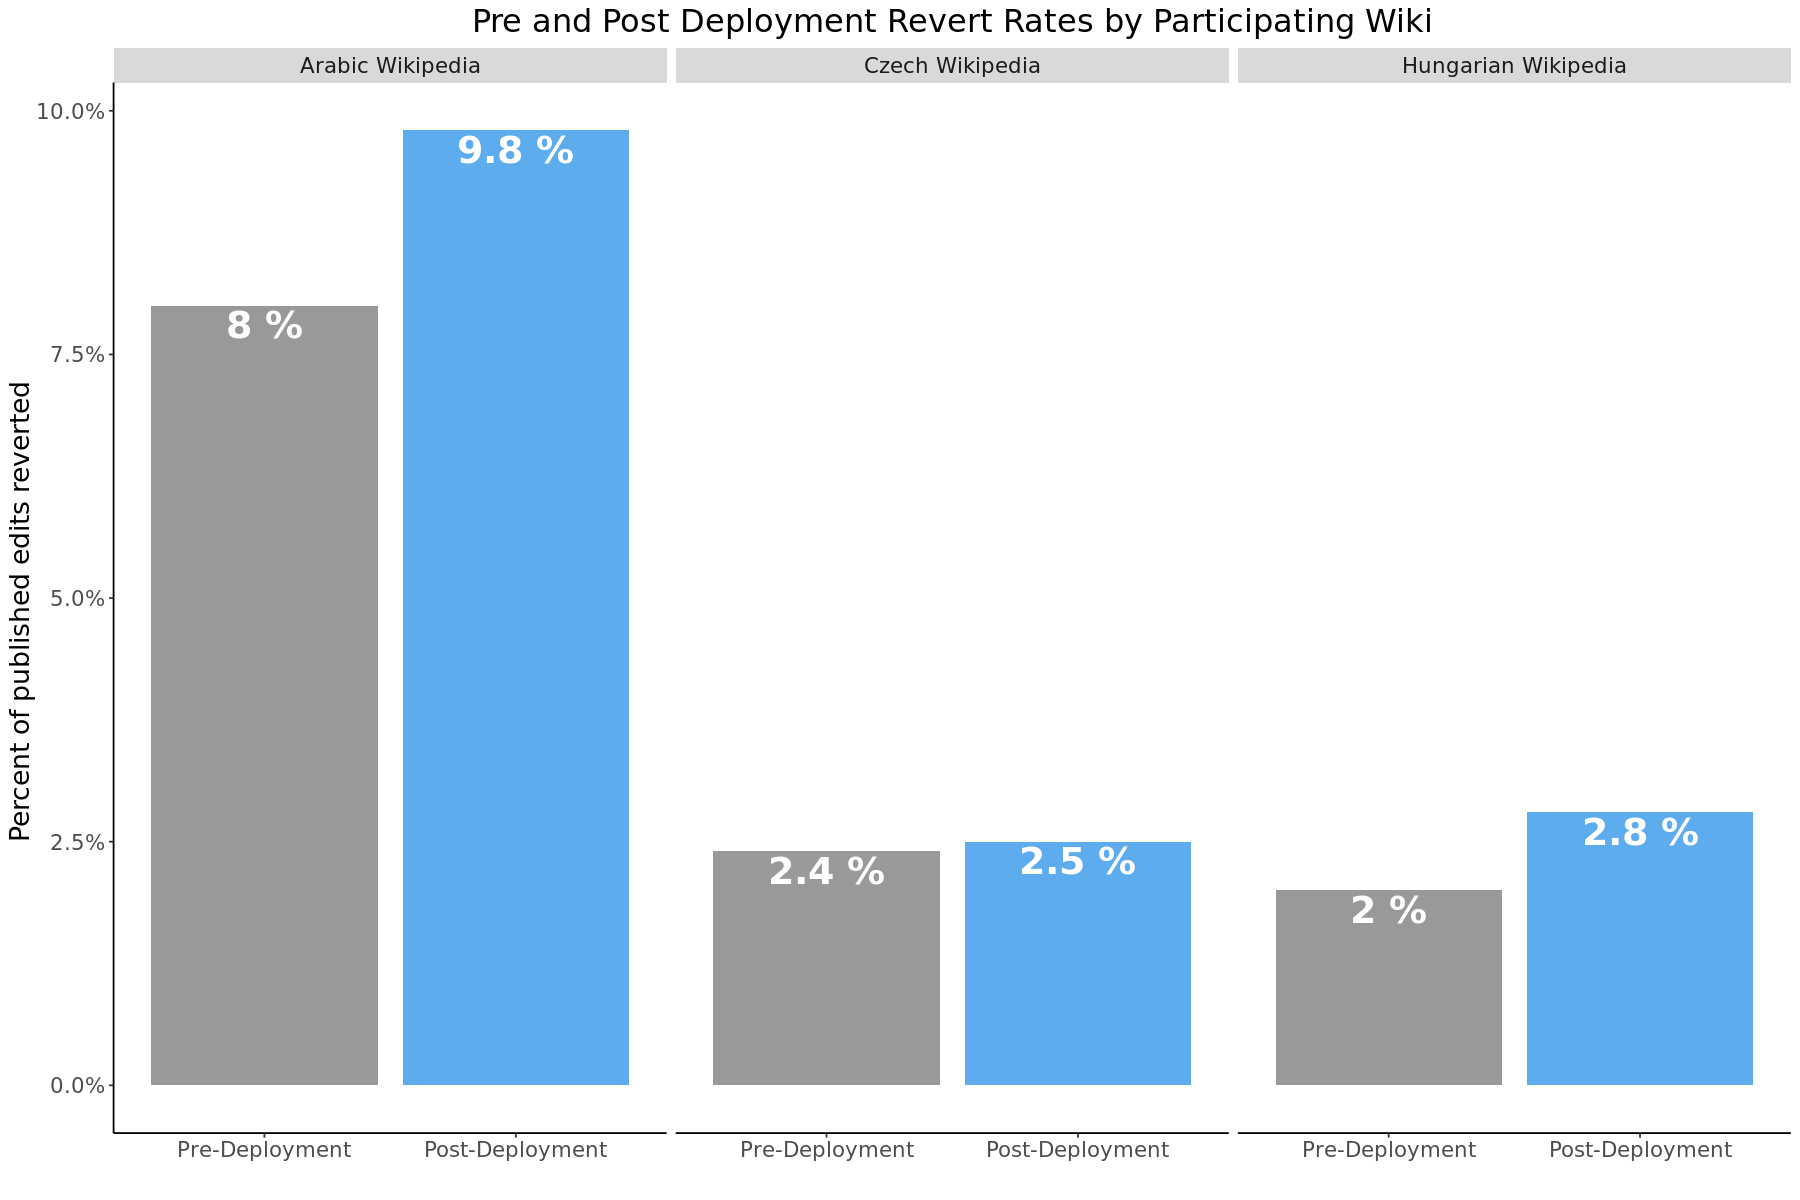

In [287]:

p <- revert_rate_pre_post_bywiki %>%
    ggplot(aes(x= pre_post, y = revert_rate, fill = pre_post)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(revert_rate * 100, "%"), fontface=2), vjust=1.2, size = 8, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    scale_x_discrete(labels = c("Pre-Deployment", "Post-Deployment")) +
    facet_wrap(~wiki) +
    labs (y = "Percent of published edits reverted ",
          x = "",
          title = "Pre and Post Deployment Revert Rates by Participating Wiki")  +
    scale_fill_manual(values= c("#999999", "steelblue2")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/revert_rate_pre_post_bywiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

We observed slight increases in overall revert rate post deployment on the participating wikis. The absolute difference is small (under 2 percentage points for all Wikipedia).  Also note, that these rates may also be impacted by other variables such as seasonalilty.

The slightly higher increase for Arabic Wikipedia is partly due to the spike in revert rates around Mar 24th, which occured 4 days after deployment of usability improvements.


## Overall 

In [288]:
revert_rate_pre_post_overall <-  revert_rate_pre_post_bywiki %>%
    group_by(pre_post) %>%
    summarise(n_edits = sum(n_edits),
              n_reverts = sum(n_reverts),
              revert_rate = paste0(round(n_reverts/n_edits * 100, 1), "%"))

revert_rate_pre_post_overall

pre_post        n_edits n_reverts revert_rate
1 Pre-Deployment  4776    204       4.3%       
2 Post-Deployment 3830    163       4.3%

We did not observe any changes in the overall talk page edit revert rate pre and post-deployment across the three participating wikis. 

## By Editor Interface

In [289]:
revert_rate_byinterface <-  revert_rate_pre_post_table  %>%
    group_by(pre_post, interface) %>%
   summarise(n_edits = sum(n_edits),
              n_reverts = sum(n_reverts),
              revert_rate = round(n_reverts/n_edits, 3))


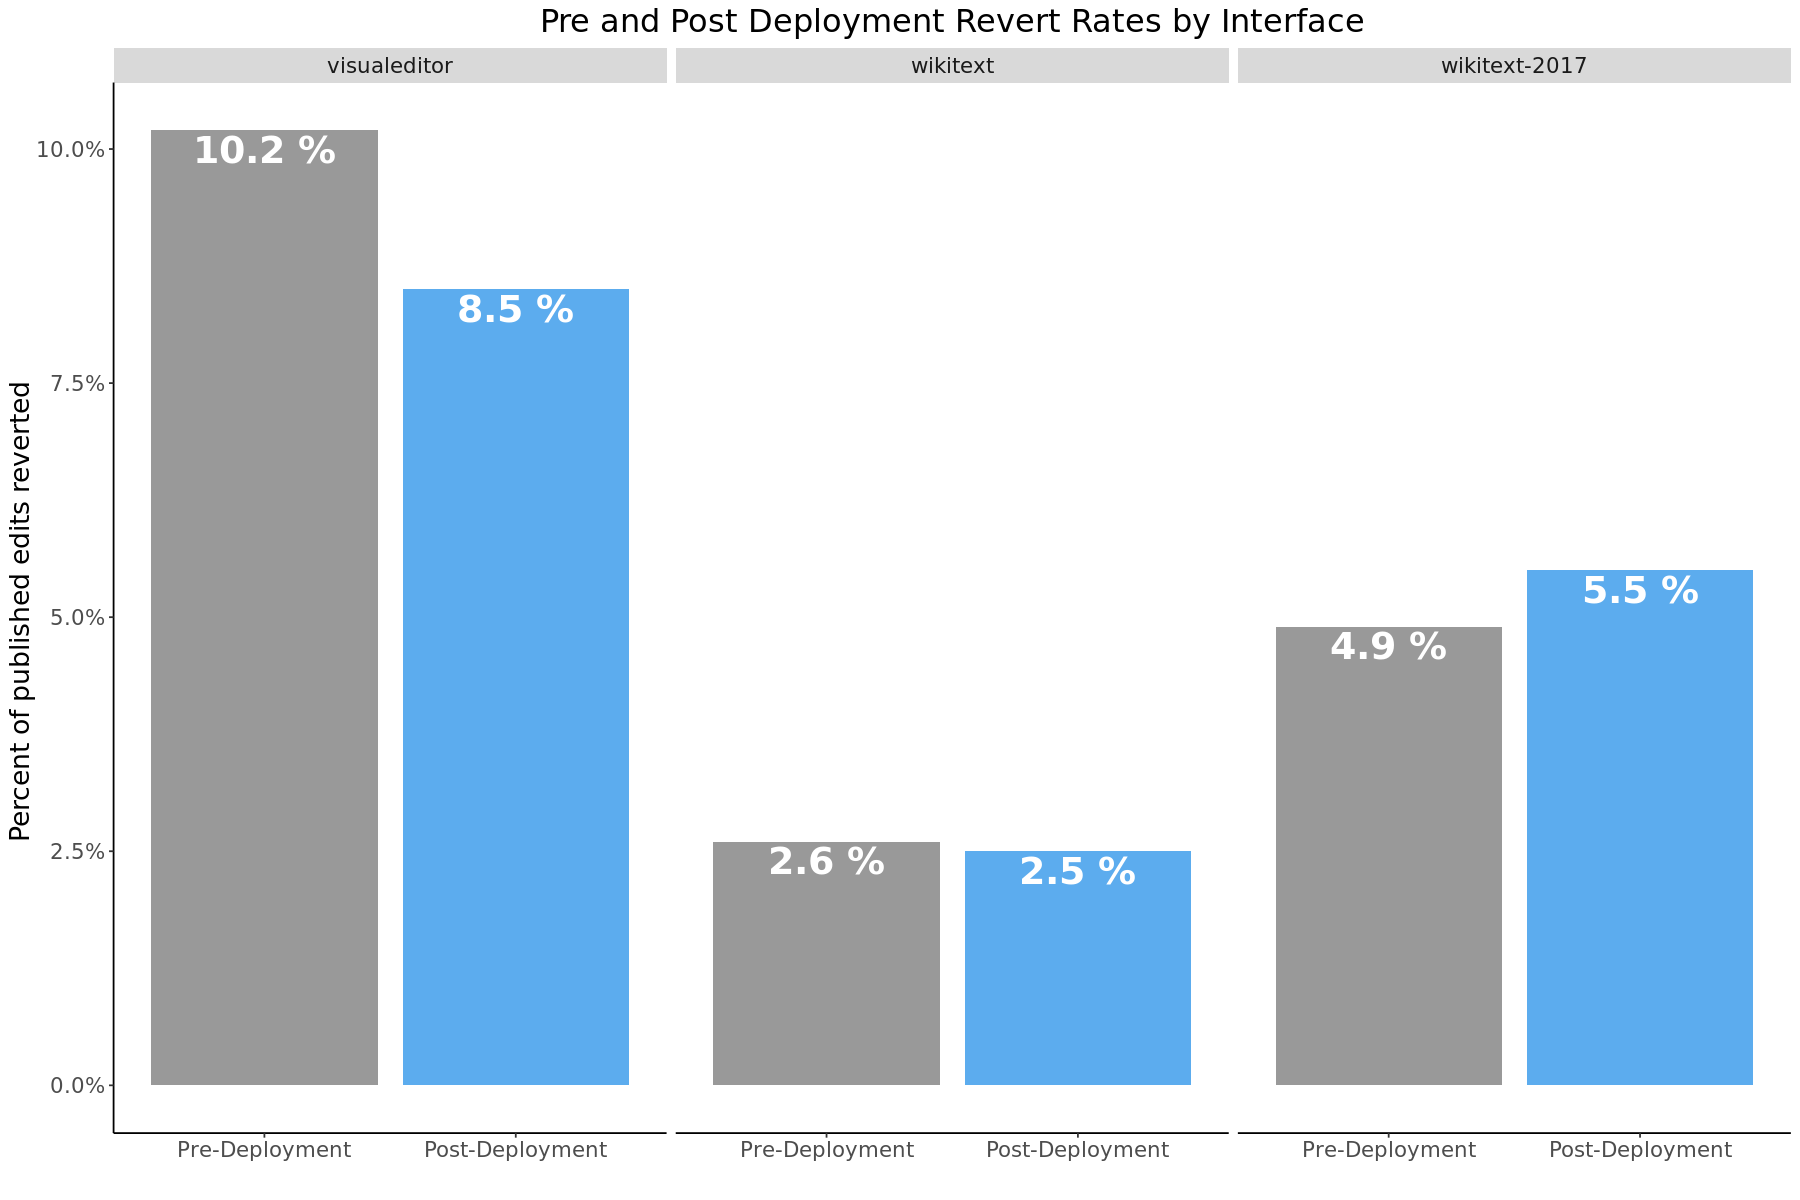

In [290]:

p <- revert_rate_byinterface  %>%
    ggplot(aes(x= pre_post, y = revert_rate, fill = pre_post)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(revert_rate * 100, "%"), fontface=2), vjust=1.2, size = 8, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    scale_x_discrete(labels = c("Pre-Deployment", "Post-Deployment")) +
    facet_wrap(~interface) +
    labs (y = "Percent of published edits reverted ",
          x = "",
          title = "Pre and Post Deployment Revert Rates by Interface")  +
    scale_fill_manual(values= c("#999999", "steelblue2")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/revert_rate_byinterface.png", p, width = 16, height = 8, units = "in", dpi = 300)

We see a -17% decrease in revert rate of talk page edits made with visual editor and -4% percent decrease in revert rate of edits made with wikitext. 

## By Editor Integration

In [291]:
revert_rate_byintegration <-  revert_rate_pre_post_table  %>%
    group_by(pre_post, integration) %>%
   summarise(n_edits = sum(n_edits),
              n_reverts = sum(n_reverts),
              revert_rate = round(n_reverts/n_edits, 3))


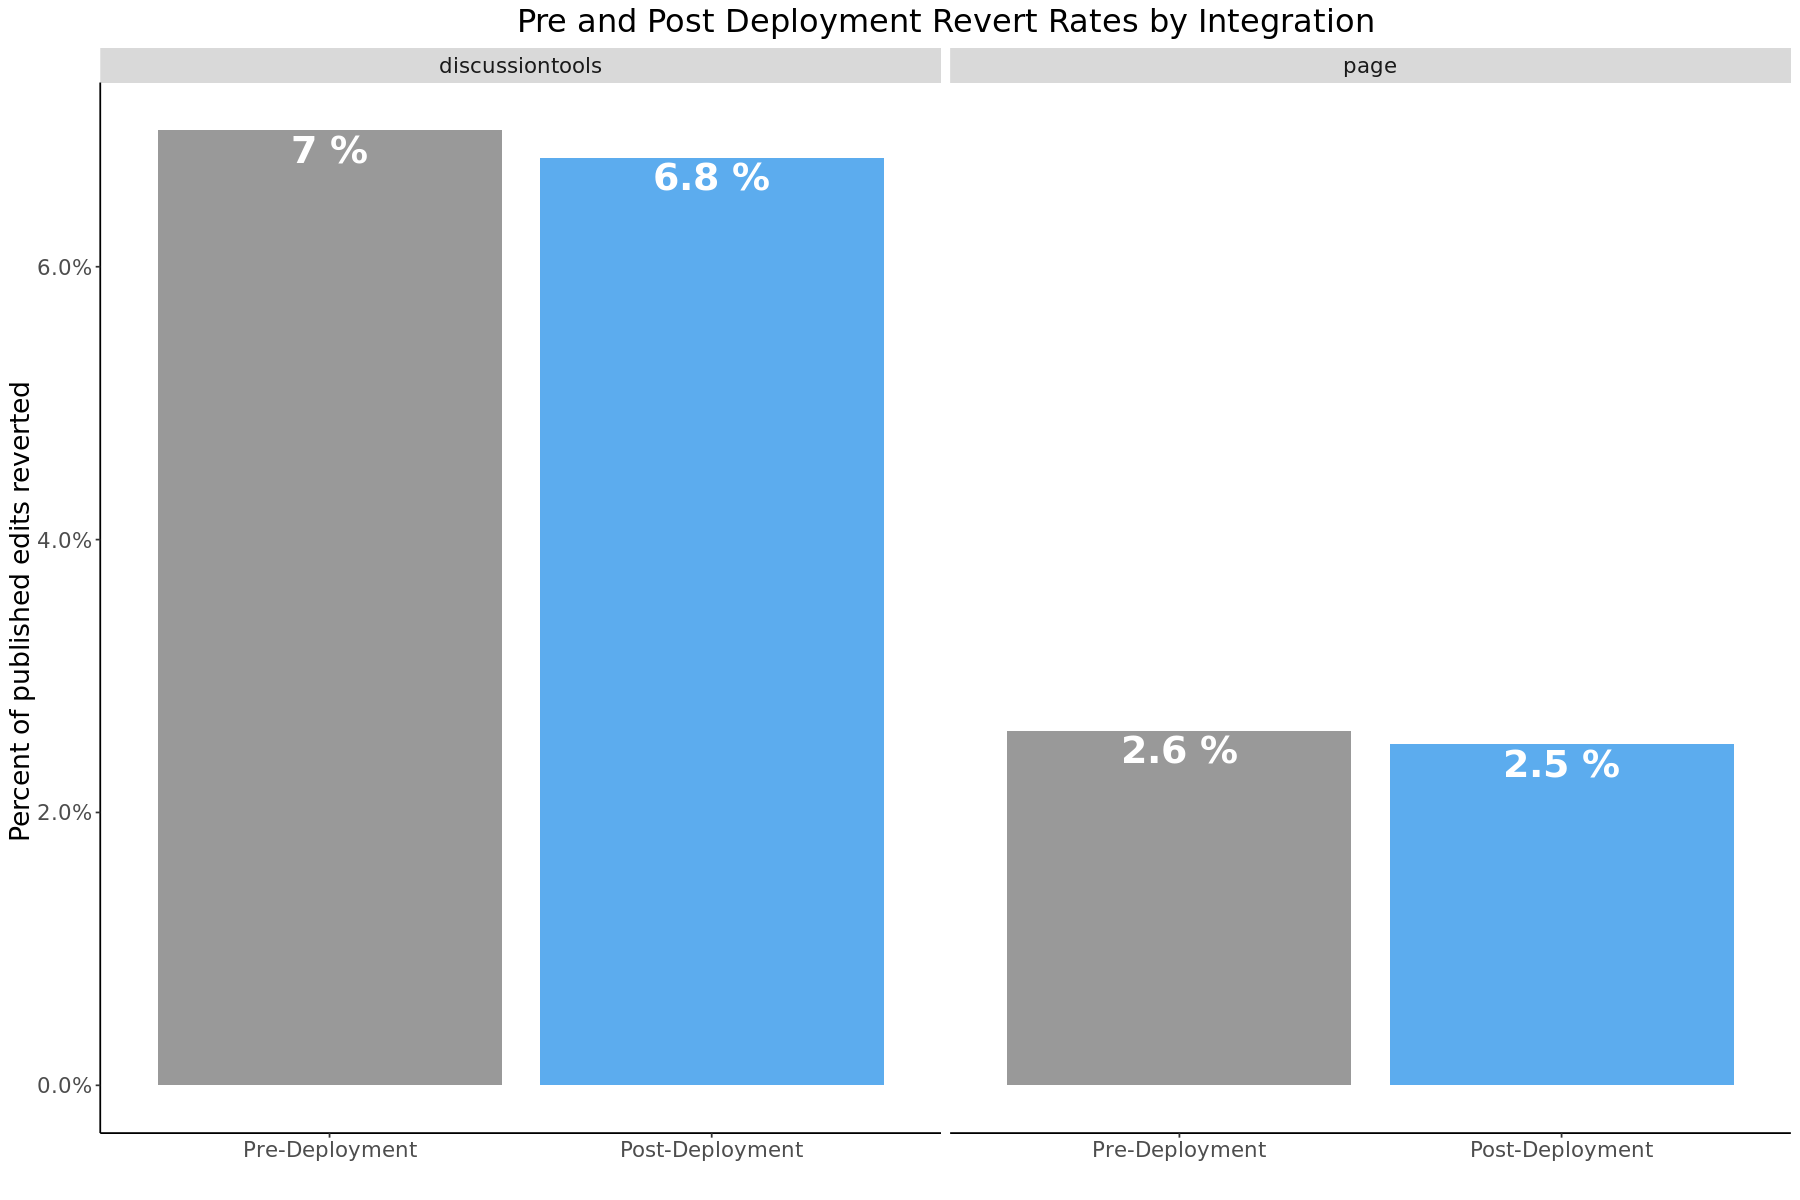

In [292]:

p <- revert_rate_byintegration  %>%
    ggplot(aes(x= pre_post, y = revert_rate, fill = pre_post)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(revert_rate * 100, "%"), fontface=2), vjust=1.2, size = 8, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    scale_x_discrete(labels = c("Pre-Deployment", "Post-Deployment")) +
    facet_wrap(~integration) +
    labs (y = "Percent of published edits reverted ",
          x = "",
          title = "Pre and Post Deployment Revert Rates by Integration")  +
    scale_fill_manual(values= c("#999999", "steelblue2")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/revert_rate_byintegration.png", p, width = 16, height = 8, units = "in", dpi = 300)

No significant changes in revert rate when broken down by integration.
  

## By User Experience Level

In [293]:
revert_rate_byexp <-  revert_rate_pre_post_table  %>%
    filter(user_status != 'logged_out') %>%
    group_by(pre_post, initial_edit_count) %>%
   summarise(n_edits = sum(n_edits),
              n_reverts = sum(n_reverts),
              revert_rate = round(n_reverts/n_edits, 3))


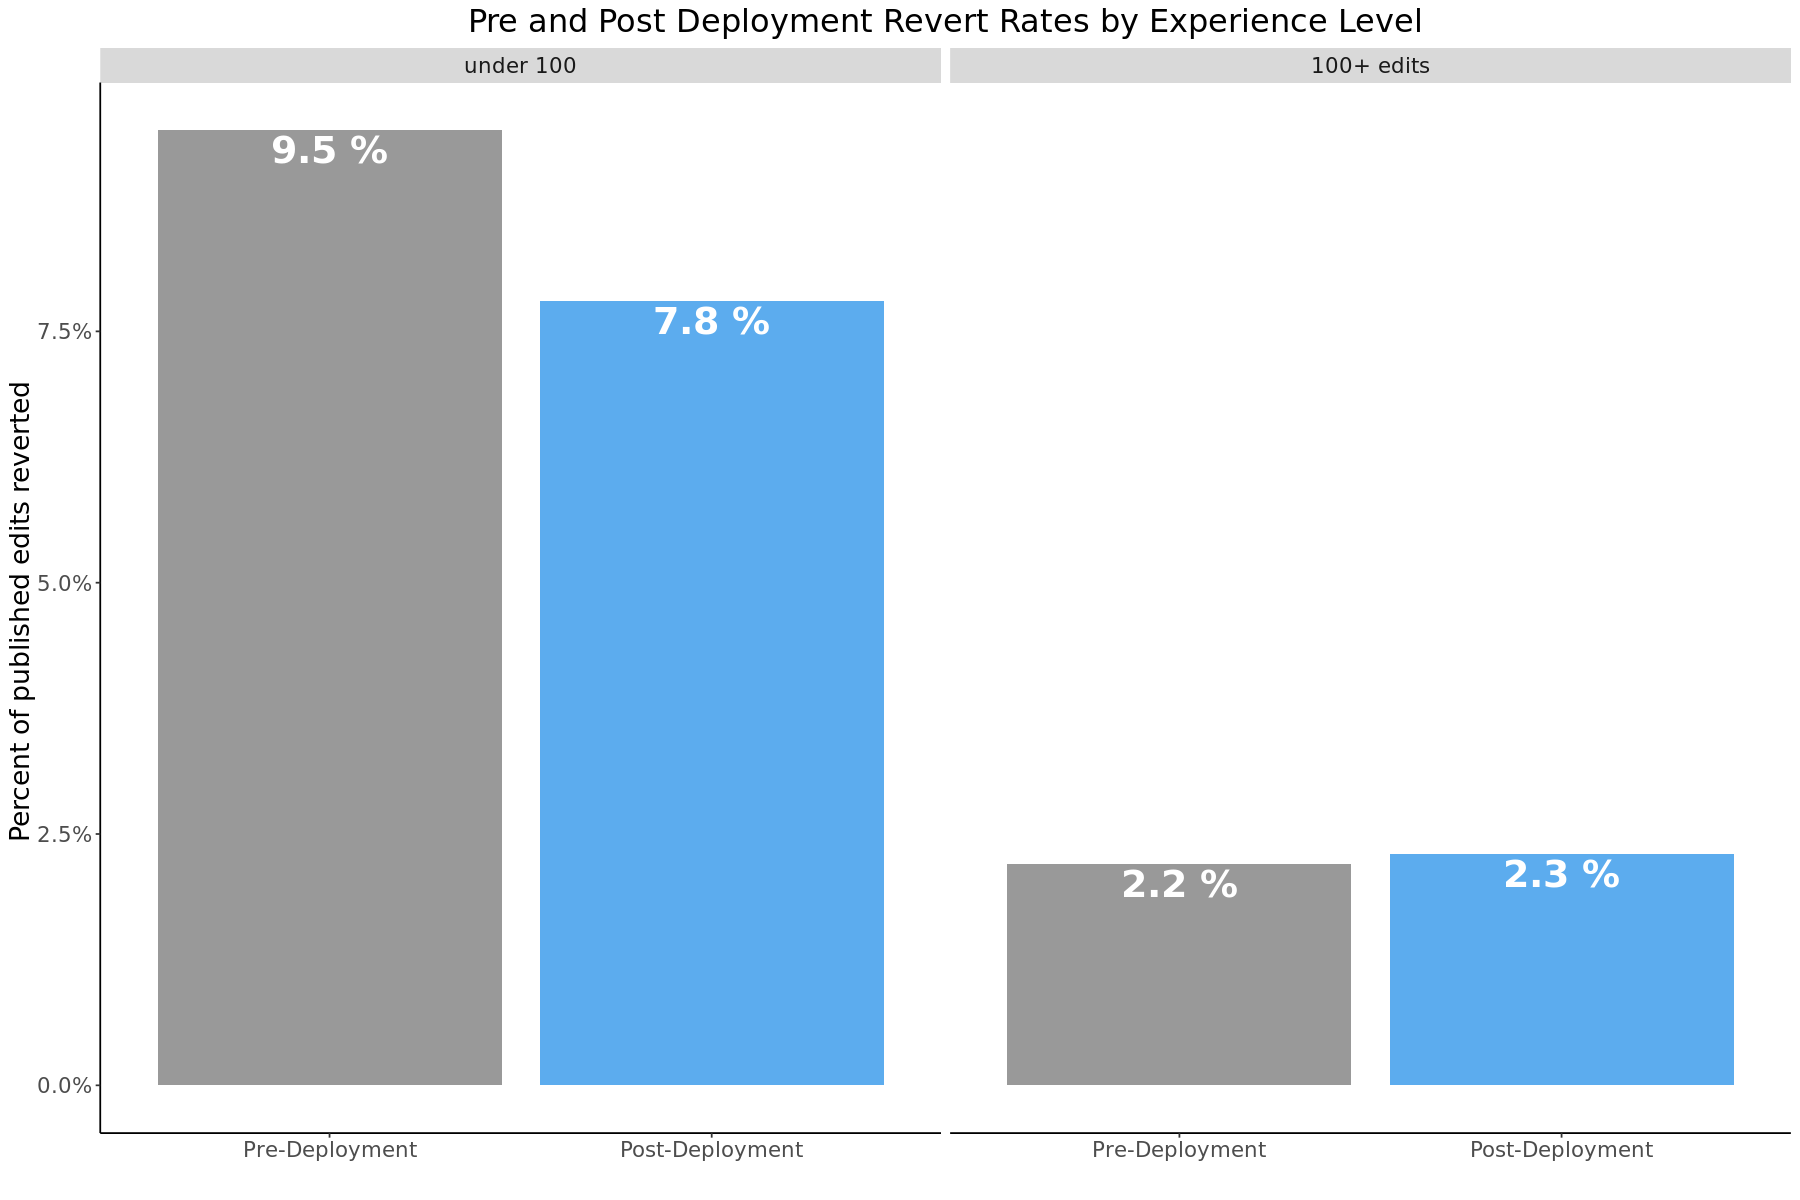

In [294]:
# plot rates

p <- revert_rate_byexp  %>%
    ggplot(aes(x= pre_post, y = revert_rate, fill = pre_post)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(revert_rate * 100, "%"), fontface=2), vjust=1.2, size = 8, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    scale_x_discrete(labels = c("Pre-Deployment", "Post-Deployment")) +
    facet_wrap(~initial_edit_count) +
    labs (y = "Percent of published edits reverted ",
          x = "",
          title = "Pre and Post Deployment Revert Rates by Experience Level")  +
    scale_fill_manual(values= c("#999999", "steelblue2")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/revert_rate_byexp.png", p, width = 16, height = 8, units = "in", dpi = 300)

Similar to other desktop talk page projects, we observed more of an impact for Junior Contributors following the deployment of a new talk page feature.
There was a -18% decrease in the revert rate of desktop talk page edits by Junior Contributors (under 100 edits) following deployment of the feature; compared to 4.5% increase (+0.1 percentage points) for Senior editors.

## Logged In Vs Logged Out

In [295]:
revert_rate_bystatus <-  revert_rate_pre_post_table  %>%
    group_by(pre_post, user_status) %>%
   summarise(n_edits = sum(n_edits),
              n_reverts = sum(n_reverts),
              revert_rate = round(n_reverts/n_edits, 3))


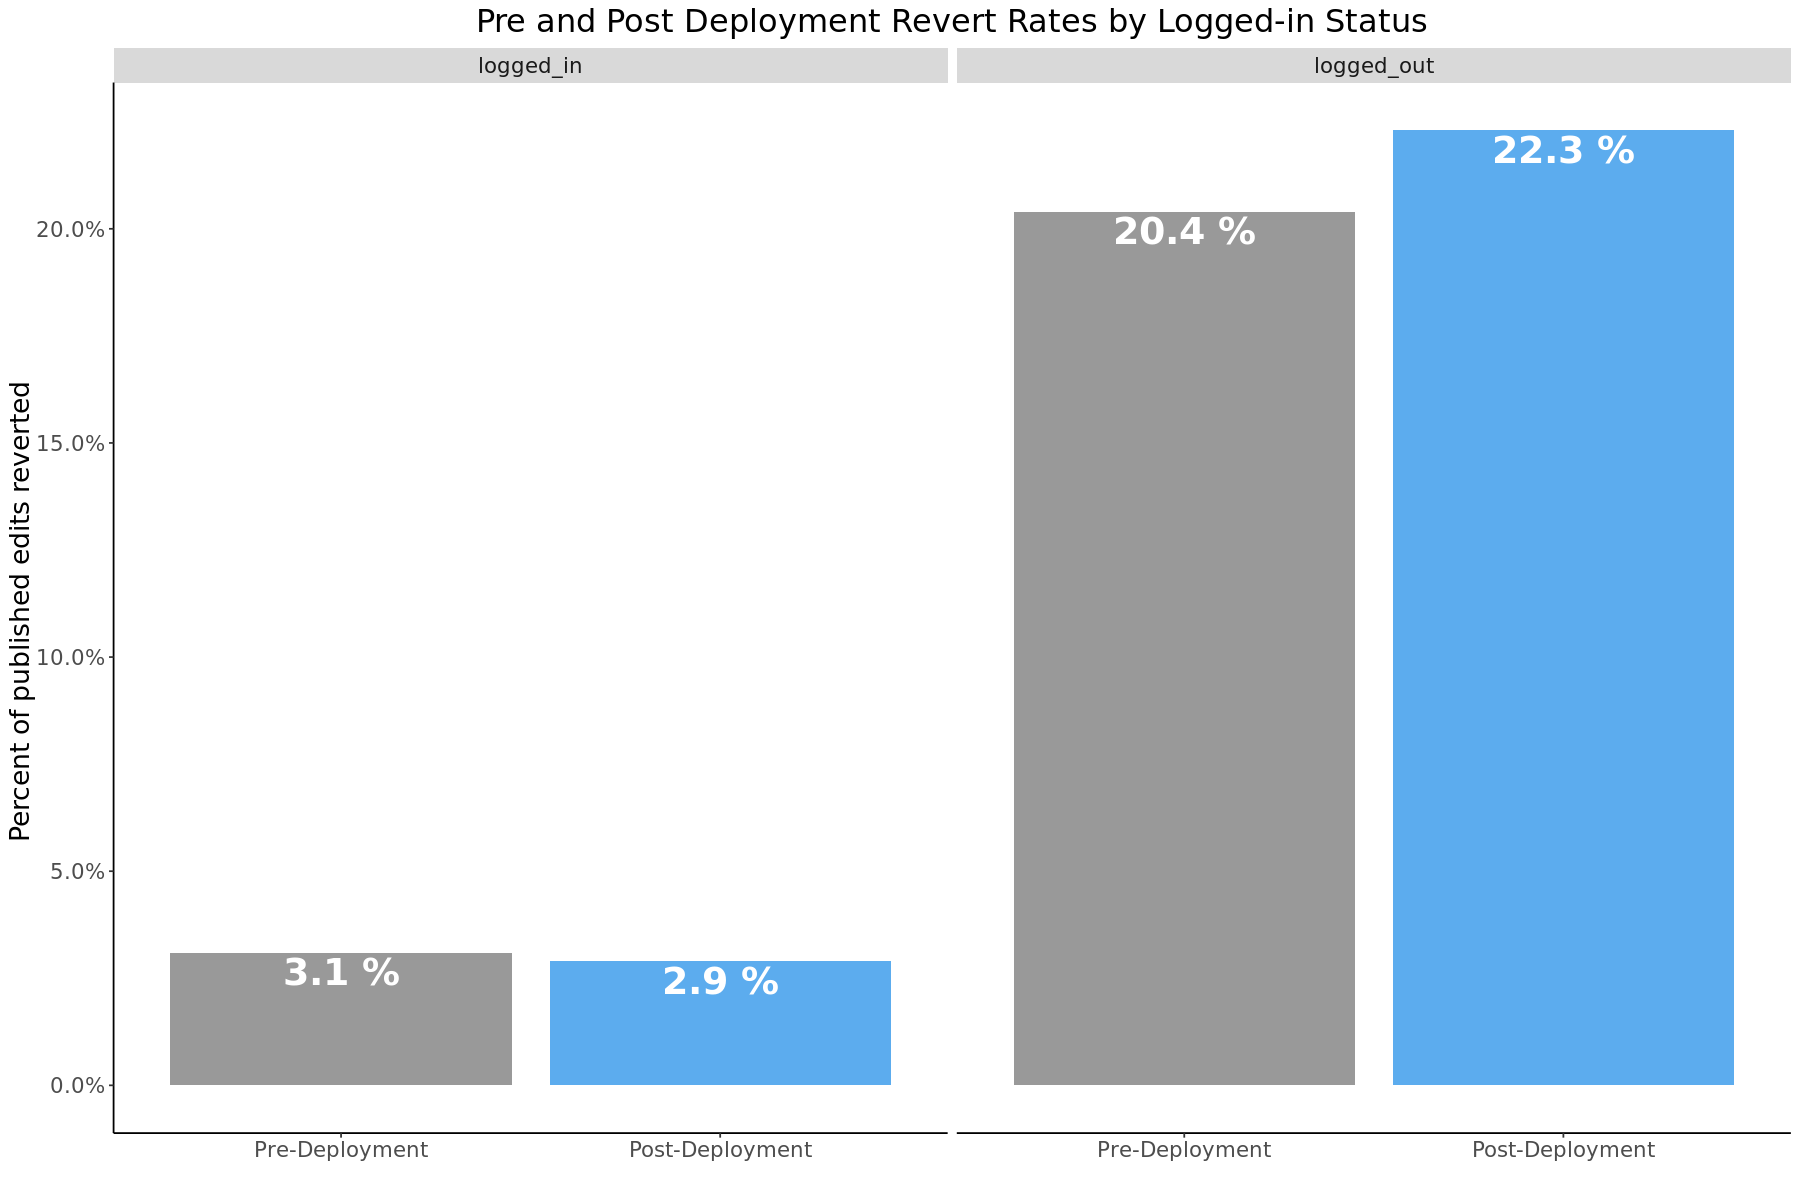

In [296]:
# plot by logged_in status

p <- revert_rate_bystatus  %>%
    ggplot(aes(x= pre_post, y = revert_rate, fill = pre_post)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(revert_rate * 100, "%"), fontface=2), vjust=1.2, size = 8, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    scale_x_discrete(labels = c("Pre-Deployment", "Post-Deployment")) +
    facet_wrap(~user_status) +
    labs (y = "Percent of published edits reverted ",
          x = "",
          title = "Pre and Post Deployment Revert Rates by Logged-in Status")  +
    scale_fill_manual(values= c("#999999", "steelblue2")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/revert_rate_bystatus.png", p, width = 16, height = 8, units = "in", dpi = 300)

We also see slight different trends when comparing logged-in and logged-out users. There was a slight decrease (-6.5%) in revert rate for logged-in users and increase (+9.3%) by logged-out users. 



# Edit Completion Rate

Defined as the proportion of edit attempts that are successfully published during the reviewed time period.

In [297]:
edit_completion_data <-
  read.csv(
    file = 'Data/edit_completion_data.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) # loads all edit completion rate data

In [298]:
# data reformatting and cleanup

edit_completion_data$date <- as.Date(edit_completion_data$date, format = "%Y-%m-%d")

#set factor levels with correct baselines

edit_completion_data$edit_success <-
  factor(
    edit_completion_data$edit_success,
    levels = c(0, 1),
    labels = c("Not Complete", "Complete")
  )


# reformat user-id and adjust to include wiki to account for duplicate user id instances.
# Users do not have the smae user_id on different wikis
edit_completion_data$user_id <-
  as.character(paste(edit_completion_data$user_id, edit_completion_data$wiki, sep ="-"))

#clarfiy wiki names
edit_completion_data <- edit_completion_data %>%
  mutate(
    wiki = case_when(
      #clarfiy participating project names
     wiki == 'cswiki' ~ "Czech Wikipedia",
      wiki == 'huwiki' ~ "Hungarian Wikipedia",
      wiki == 'arwiki' ~ "Arabic Wikipedia",  
    ) )

# group user edit count 
edit_completion_data <- edit_completion_data  %>%
 mutate(
    experience_level = case_when(
     experience_level < 100  ~ "under 100",
    experience_level >= 100 ~ '100+ edits'  
    )
  ) 


# add factor levels to exp level
edit_completion_data$ experience_level <-
  factor(edit_completion_data$experience_level,
         levels = c("under 100", "100+ edits"))

## Daily Trends

In [299]:
edit_completion_rate_daily <- edit_completion_data %>%
    group_by (date, wiki) %>%
    summarise(n_attempts = n_distinct(edit_attempt_id),
              n_saves = n_distinct(edit_attempt_id[edit_success == 'Complete']),
              completion_rate = n_saves/n_attempts)


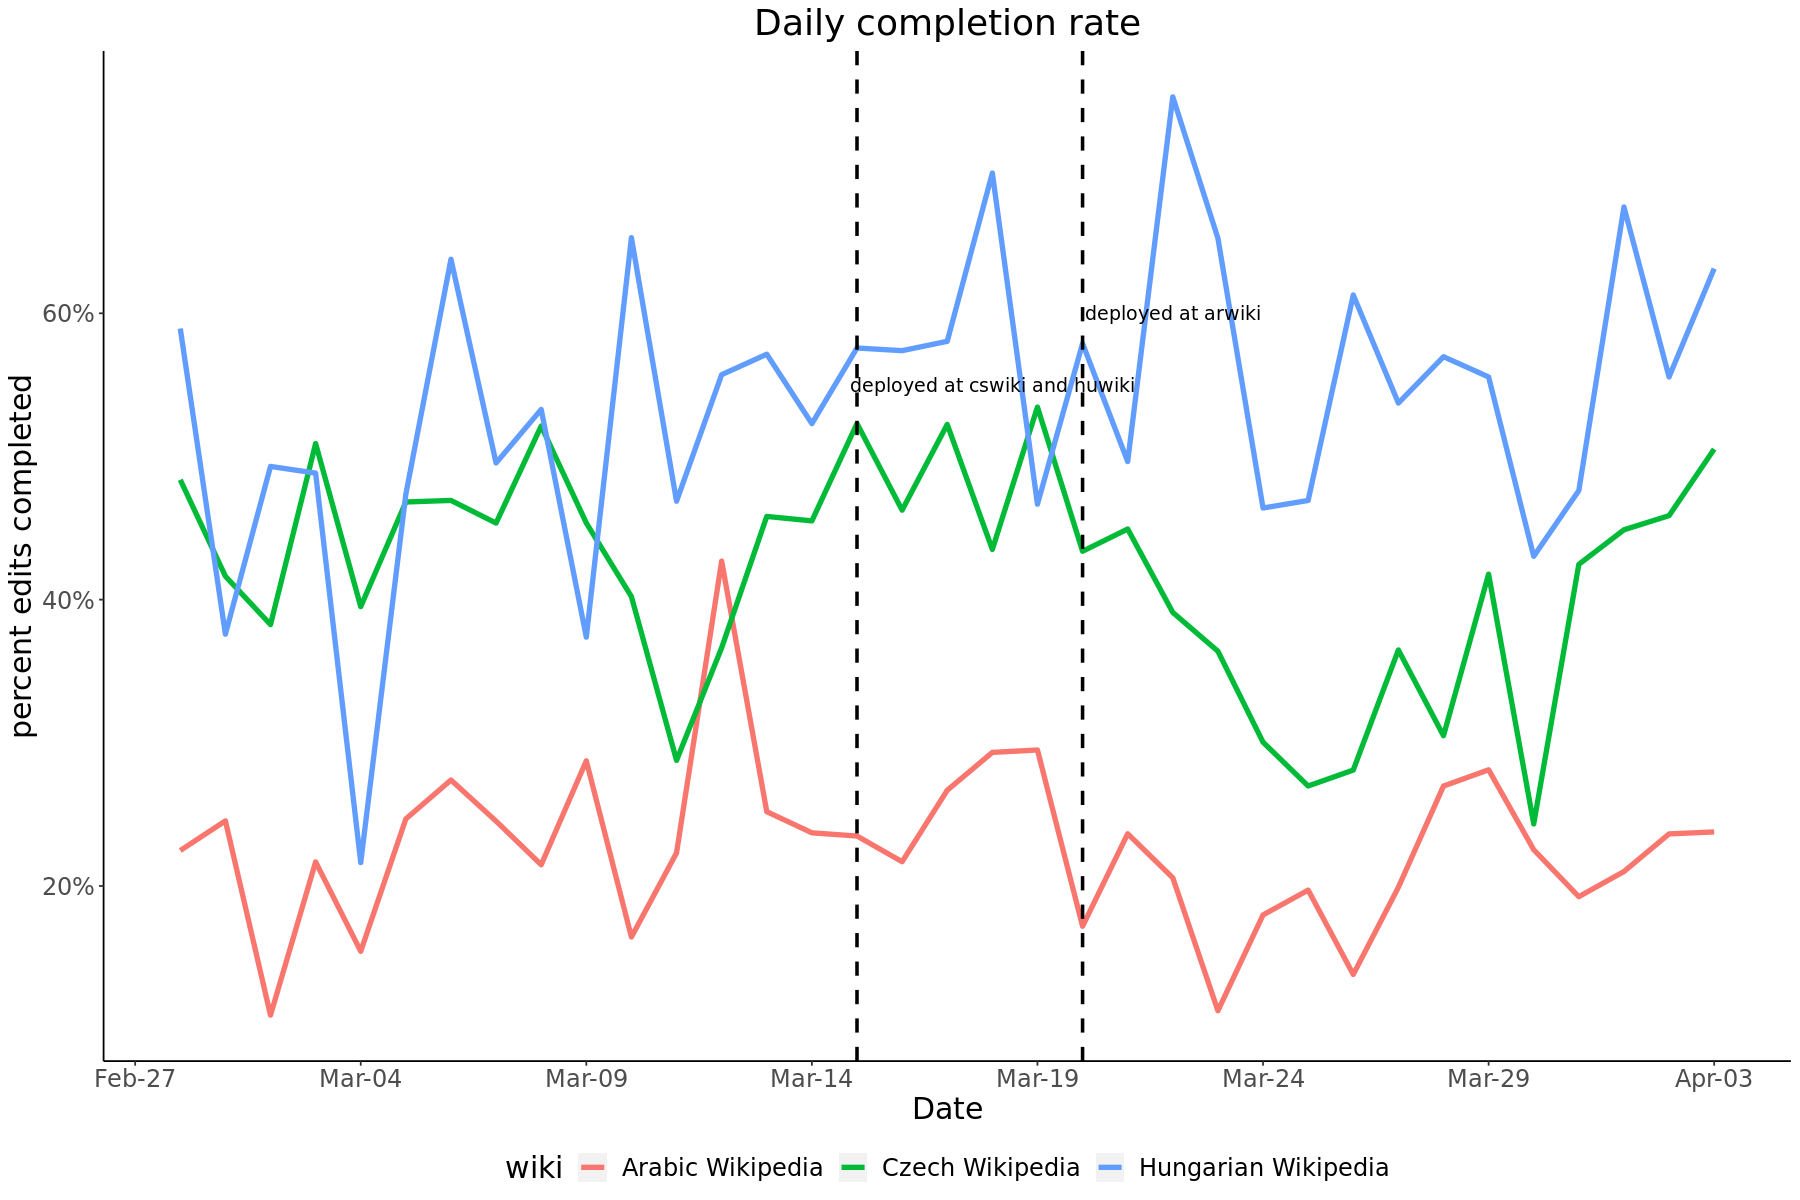

In [300]:
# plot daily session length before and after deployment of English Wikipedia

textaes <- data.frame(y = c(0.55, 0.60),
                      x = as.Date(c('2023-03-18','2023-03-22')),
                      lab = c('deployed at cswiki and huwiki', 'deployed at arwiki' ))

p <- edit_completion_rate_daily  %>%
    ggplot(aes(x= date, y = completion_rate, color = wiki)) +    
    geom_line(size =1.5) +
    geom_vline(xintercept = as.Date(c('2023-03-15','2023-03-20')), linetype = 'dashed', size = 1) +
     geom_text(mapping = aes(y = y, x = x, label = lab), 
            data = textaes, inherit.aes = FALSE, size = 4) +
    scale_y_continuous(labels = scales::percent) +
    scale_x_date("Date", date_breaks = "5 days", date_labels = "%b-%d") +
  labs(title = "Daily completion rate",
      y = "percent edits completed",
      x= "Date") +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 

p

ggsave("Figures/completion_rate_daily.png", p, width = 16, height = 8, units = "in", dpi = 300) 

There were no immediate changes in the daily edit completion rate following deployment of the feature at either of the three participating wikipedias.

## Two Weeks Pre and Post Deployment 

In [301]:
# completion rate at cswiki and huwiki 
completion_rate_pre_post_cshu <- edit_completion_data %>%
    filter(wiki != 'Arabic Wikipedia') %>%
    filter(date >= '2023-02-28' & date <= '2023-03-29') %>% # two weeks before and after
    mutate(pre_post = ifelse(date < '2023-03-15', 'pre', 'post')) %>%
    group_by (wiki, user_status, pre_post, interface, integration, experience_level)  %>%
     summarise(n_attempts = n_distinct(edit_attempt_id),
              n_saves = n_distinct(edit_attempt_id[edit_success == 'Complete']),
              completion_rate = n_saves/n_attempts)

In [302]:
# completion rate at arwiki
completion_rate_pre_post_arwiki <- edit_completion_data %>%
    filter(wiki == 'Arabic Wikipedia') %>%
    filter(date >= '2023-03-05' & date <= '2023-04-03') %>% # two weeks before and after
    mutate(pre_post = ifelse(date < '2023-03-20', 'pre', 'post')) %>%
    group_by (wiki, user_status, pre_post, interface, integration, experience_level)  %>%
      summarise(n_attempts = n_distinct(edit_attempt_id),
              n_saves = n_distinct(edit_attempt_id[edit_success == 'Complete']),
              completion_rate = n_saves/n_attempts)

In [303]:
# Join two dfs
completion_rate_pre_post_table <- rbind(completion_rate_pre_post_cshu, completion_rate_pre_post_arwiki ) %>%
        mutate(pre_post = factor(
    pre_post,
    levels = c('pre', 'post'),
    labels = c("Pre-Deployment", "Post-Deployment"))
  )


## By Wiki

In [305]:
completion_rate_pre_post_bywiki  <- completion_rate_pre_post_table %>%
    group_by(wiki, pre_post) %>%
    summarise(n_saves = sum(n_saves),
              n_attempts = sum(n_attempts),
              completion_rate = round(n_saves/n_attempts, 3))


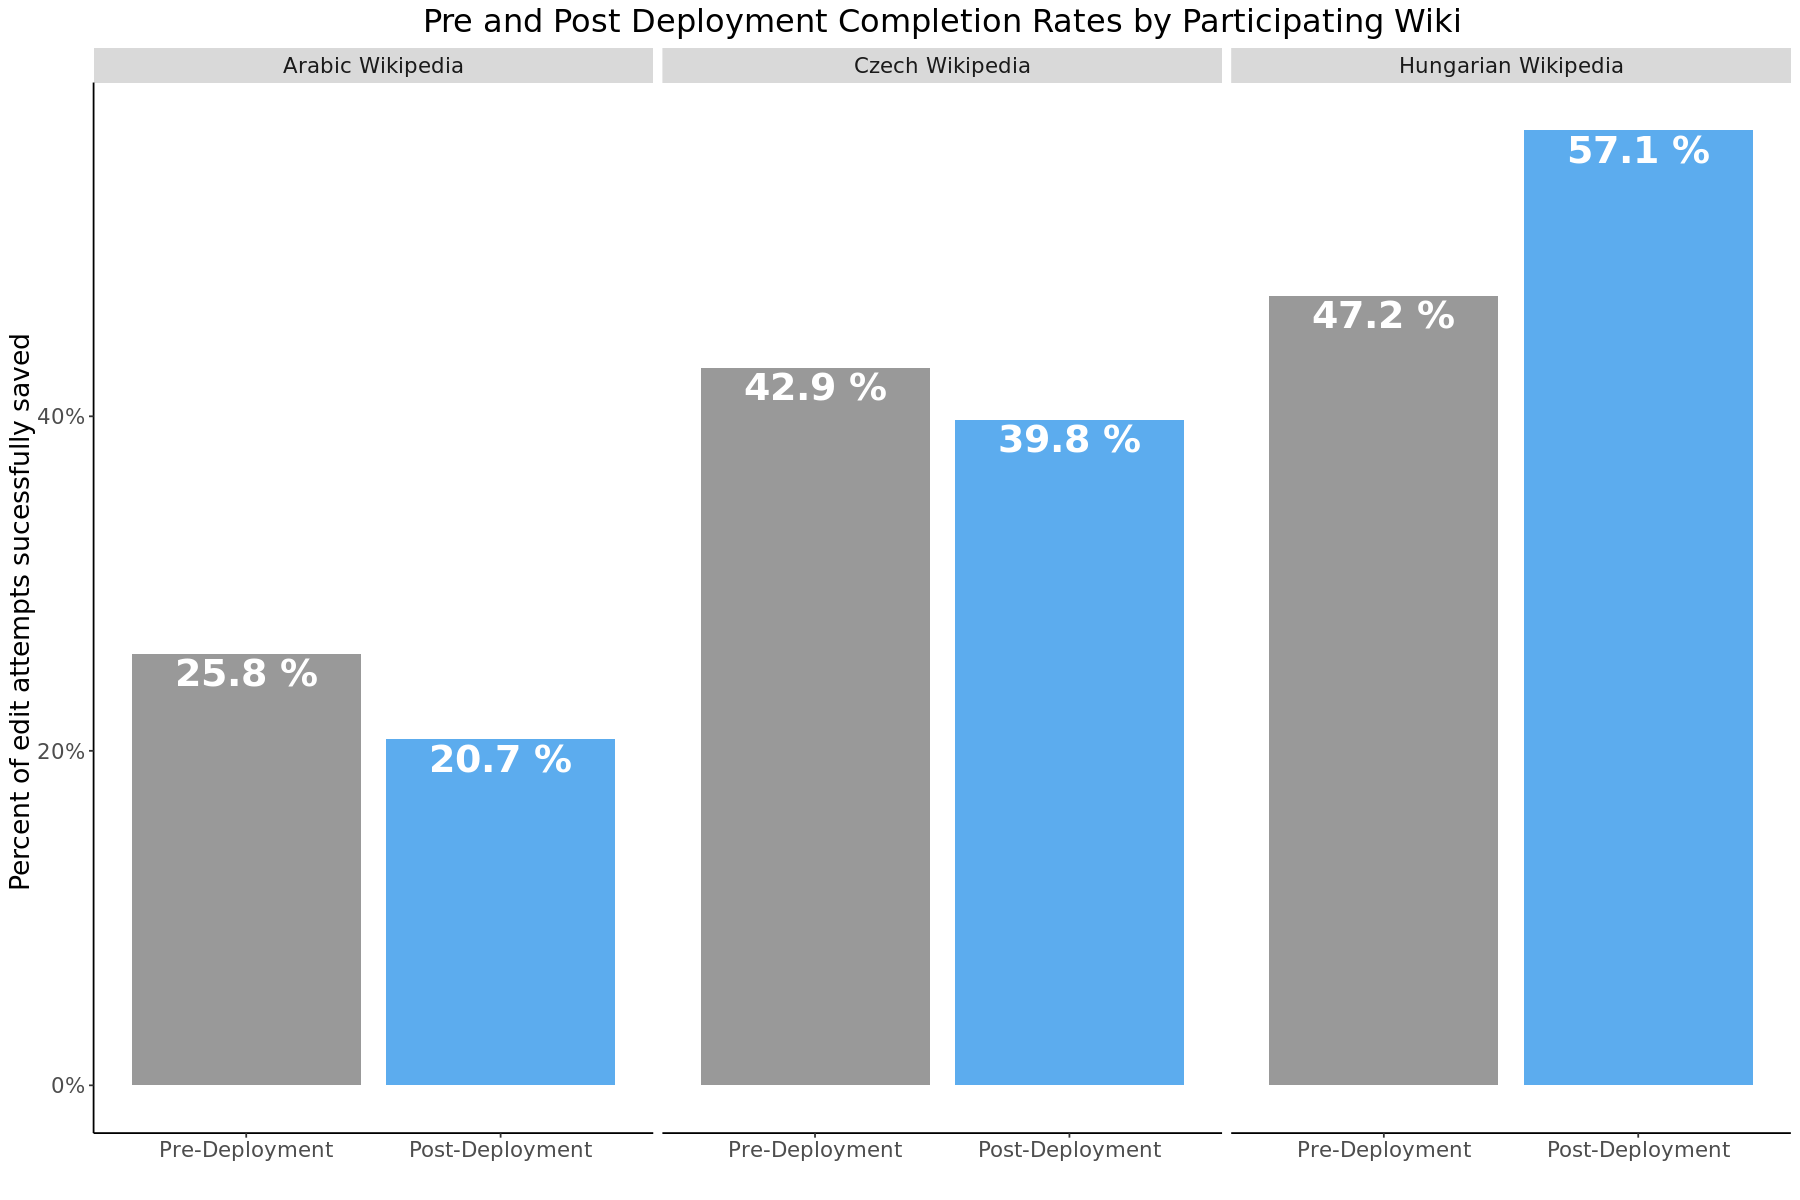

In [306]:
p <- completion_rate_pre_post_bywiki  %>%
    ggplot(aes(x= pre_post, y = completion_rate, fill = pre_post)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(completion_rate * 100, "%"), fontface=2), vjust=1.2, size = 8, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    scale_x_discrete(labels = c("Pre-Deployment", "Post-Deployment")) +
    facet_wrap(~wiki) +
    labs (y = "Percent of edit attempts sucessfully saved ",
          x = "",
          title = "Pre and Post Deployment Completion Rates by Participating Wiki")  +
    scale_fill_manual(values= c("#999999", "steelblue2")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/completion_rate_pre_post_bywiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

Per wiki results vary. We observered an increase (21% increase) at Hungarian Wikipedia while we observed a decrease at Arabic (-19.8% decrease) and Czech Wikipedias (-7.2% decrease).

## Overall

In [307]:
completion_rate_pre_post_overall <-  completion_rate_pre_post_bywiki %>%
    group_by(pre_post) %>%
    summarise(n_attempts = sum(n_attempts),
              n_saves = sum(n_saves),
              completion_rate = paste0(round(n_saves/n_attempts * 100, 1), "%"))

completion_rate_pre_post_overall 

pre_post        n_attempts n_saves completion_rate
1 Pre-Deployment  13065      4646    35.6%          
2 Post-Deployment 12479      4234    33.9%

Overall across all three participating wikis, we observed a -4.8 percent decrease in edit completion rate but in context of other breakdowns (summarized below) and the steady completion rates shown in the “Daily edit completion rate” chart above, this does not seem to be based solely on usability improvements deployment or more likely other factors. An AB test will help confirm. 

## By Editor Interface

In [308]:
completion_rate_pre_post_byinterface <-  completion_rate_pre_post_table %>%
    group_by(pre_post, interface) %>%
    summarise(n_attempts = sum(n_attempts),
              n_saves = sum(n_saves),
              completion_rate = round(n_saves/n_attempts, 3))


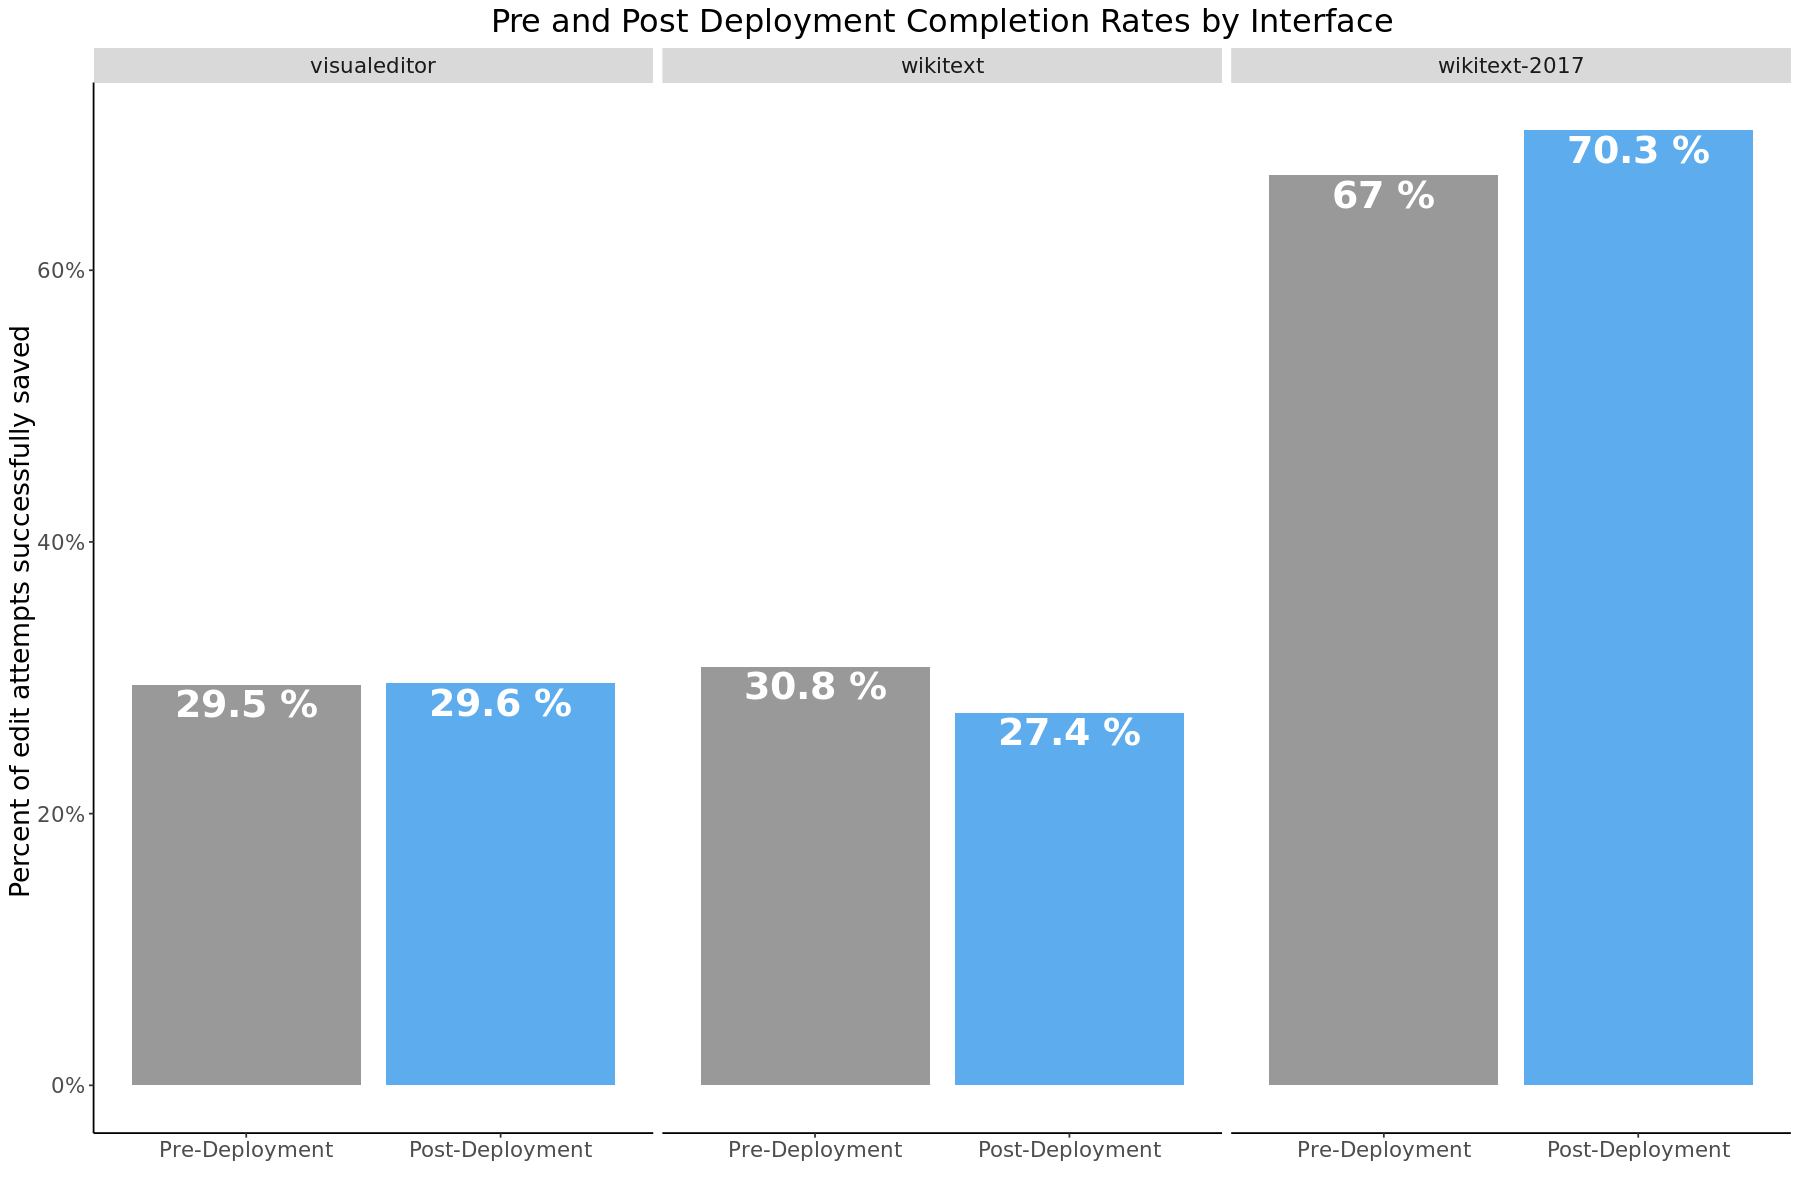

In [309]:
p <- completion_rate_pre_post_byinterface  %>%
    ggplot(aes(x= pre_post, y = completion_rate, fill = pre_post)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(completion_rate * 100, "%"), fontface=2), vjust=1.2, size = 8, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    scale_x_discrete(labels = c("Pre-Deployment", "Post-Deployment")) +
    facet_wrap(~interface) +
    labs (y = "Percent of edit attempts successfully saved ",
          x = "",
          title = "Pre and Post Deployment Completion Rates by Interface")  +
    scale_fill_manual(values= c("#999999", "steelblue2")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/completion_rate_pre_post_byinterface.png", p, width = 16, height = 8, units = "in", dpi = 300)

We observed slight increases in edit completion rate for talk page edits completed using visual editor and wikitext-2017 and observed a slight decrease for wikitext edits.

## By Integration

In [310]:
completion_rate_pre_post_byintegration <-  completion_rate_pre_post_table %>%
    group_by(pre_post, integration) %>%
    summarise(n_attempts = sum(n_attempts),
              n_saves = sum(n_saves),
              completion_rate = round(n_saves/n_attempts, 3))

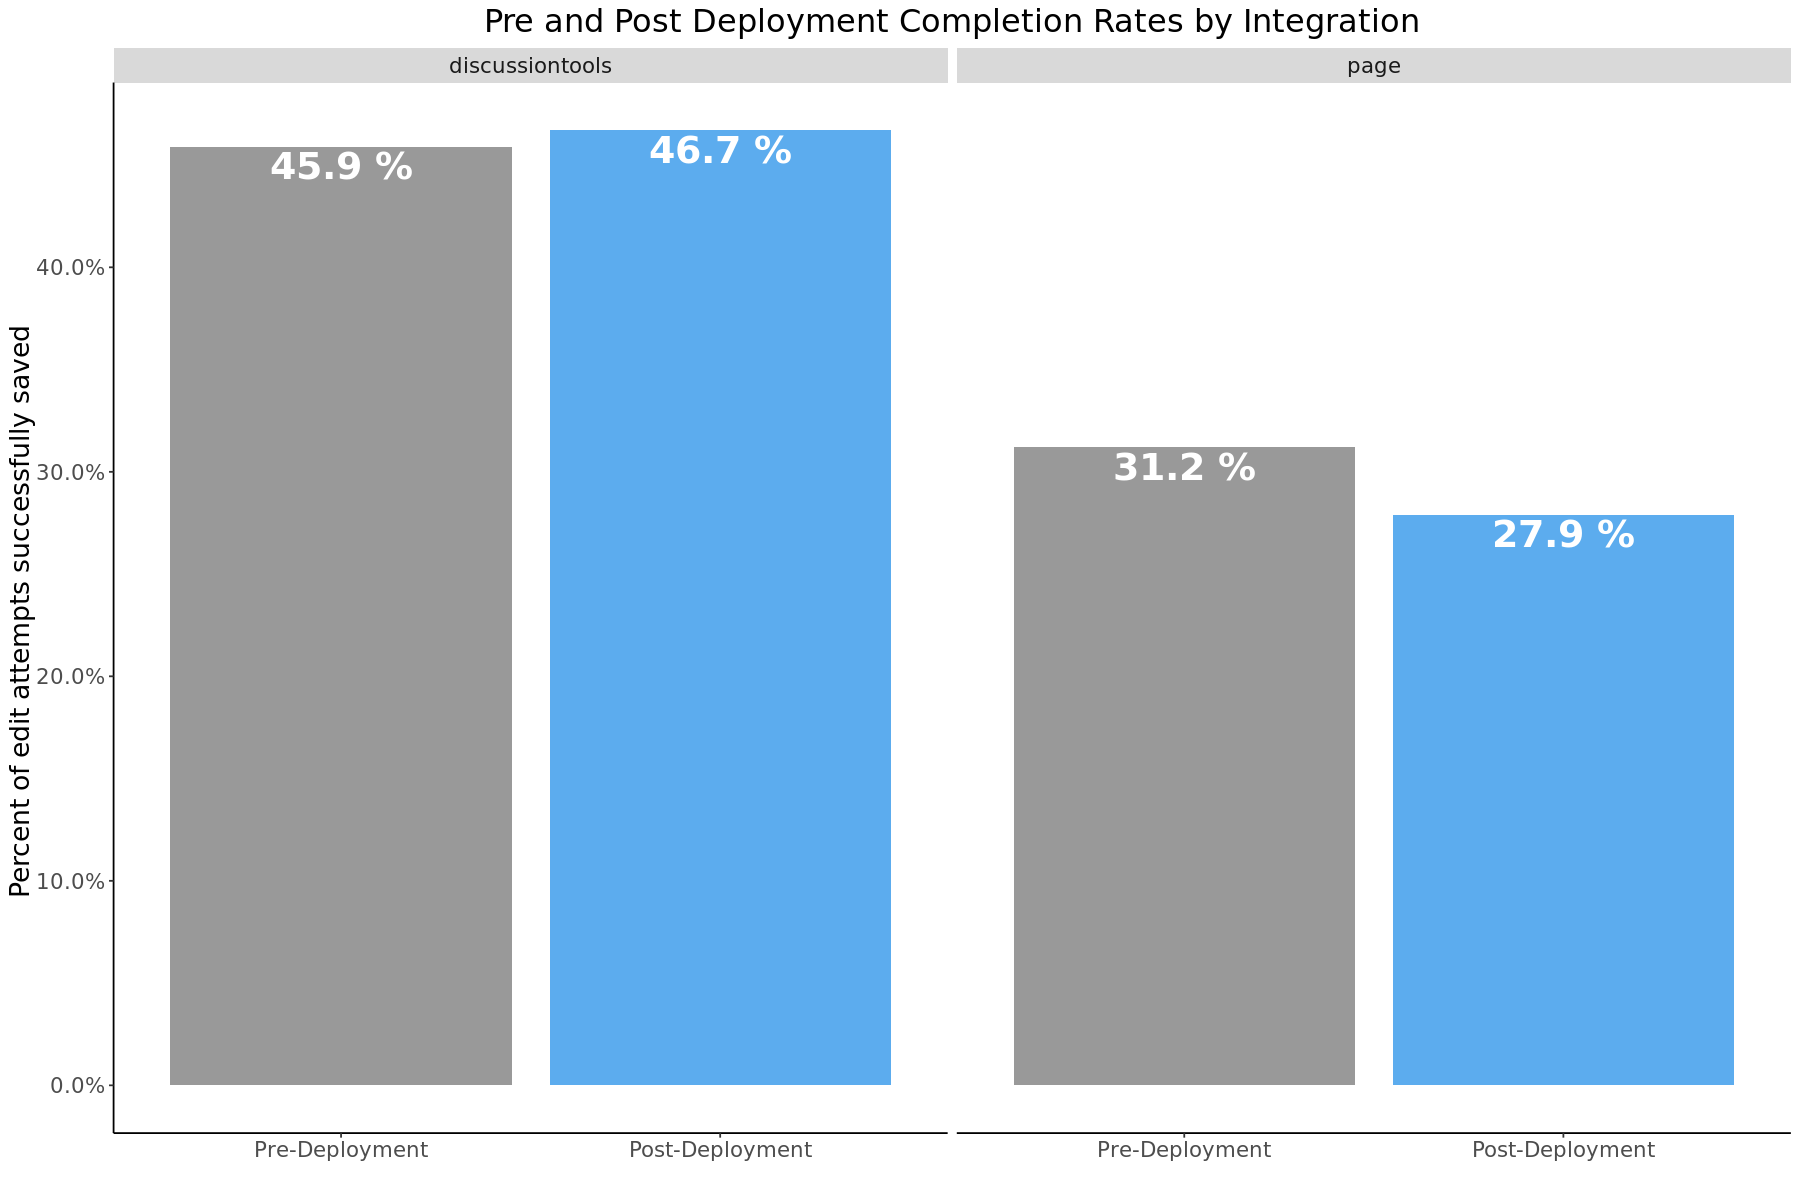

In [311]:
p <- completion_rate_pre_post_byintegration  %>%
    ggplot(aes(x= pre_post, y = completion_rate, fill = pre_post)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(completion_rate * 100, "%"), fontface=2), vjust=1.2, size = 8, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    scale_x_discrete(labels = c("Pre-Deployment", "Post-Deployment")) +
    facet_wrap(~integration) +
    labs (y = "Percent of edit attempts successfully saved ",
          x = "",
          title = "Pre and Post Deployment Completion Rates by Integration")  +
    scale_fill_manual(values= c("#999999", "steelblue2")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/completion_rate_pre_post_byintegration.png", p, width = 16, height = 8, units = "in", dpi = 300)

Varying trends when broken down by integration (discussiontools vs page). We observed a 1.7% increase with discussiontools edits and -10.6% decrease with page edits. 

## By User Experience Level

In [312]:
completion_rate_pre_post_byexp <-  completion_rate_pre_post_table %>%
    filter(user_status != 'logged_out') %>% # remove logged_out users
    group_by(pre_post, experience_level) %>%
    summarise(n_attempts = sum(n_attempts),
              n_saves = sum(n_saves),
              completion_rate = round(n_saves/n_attempts, 3))


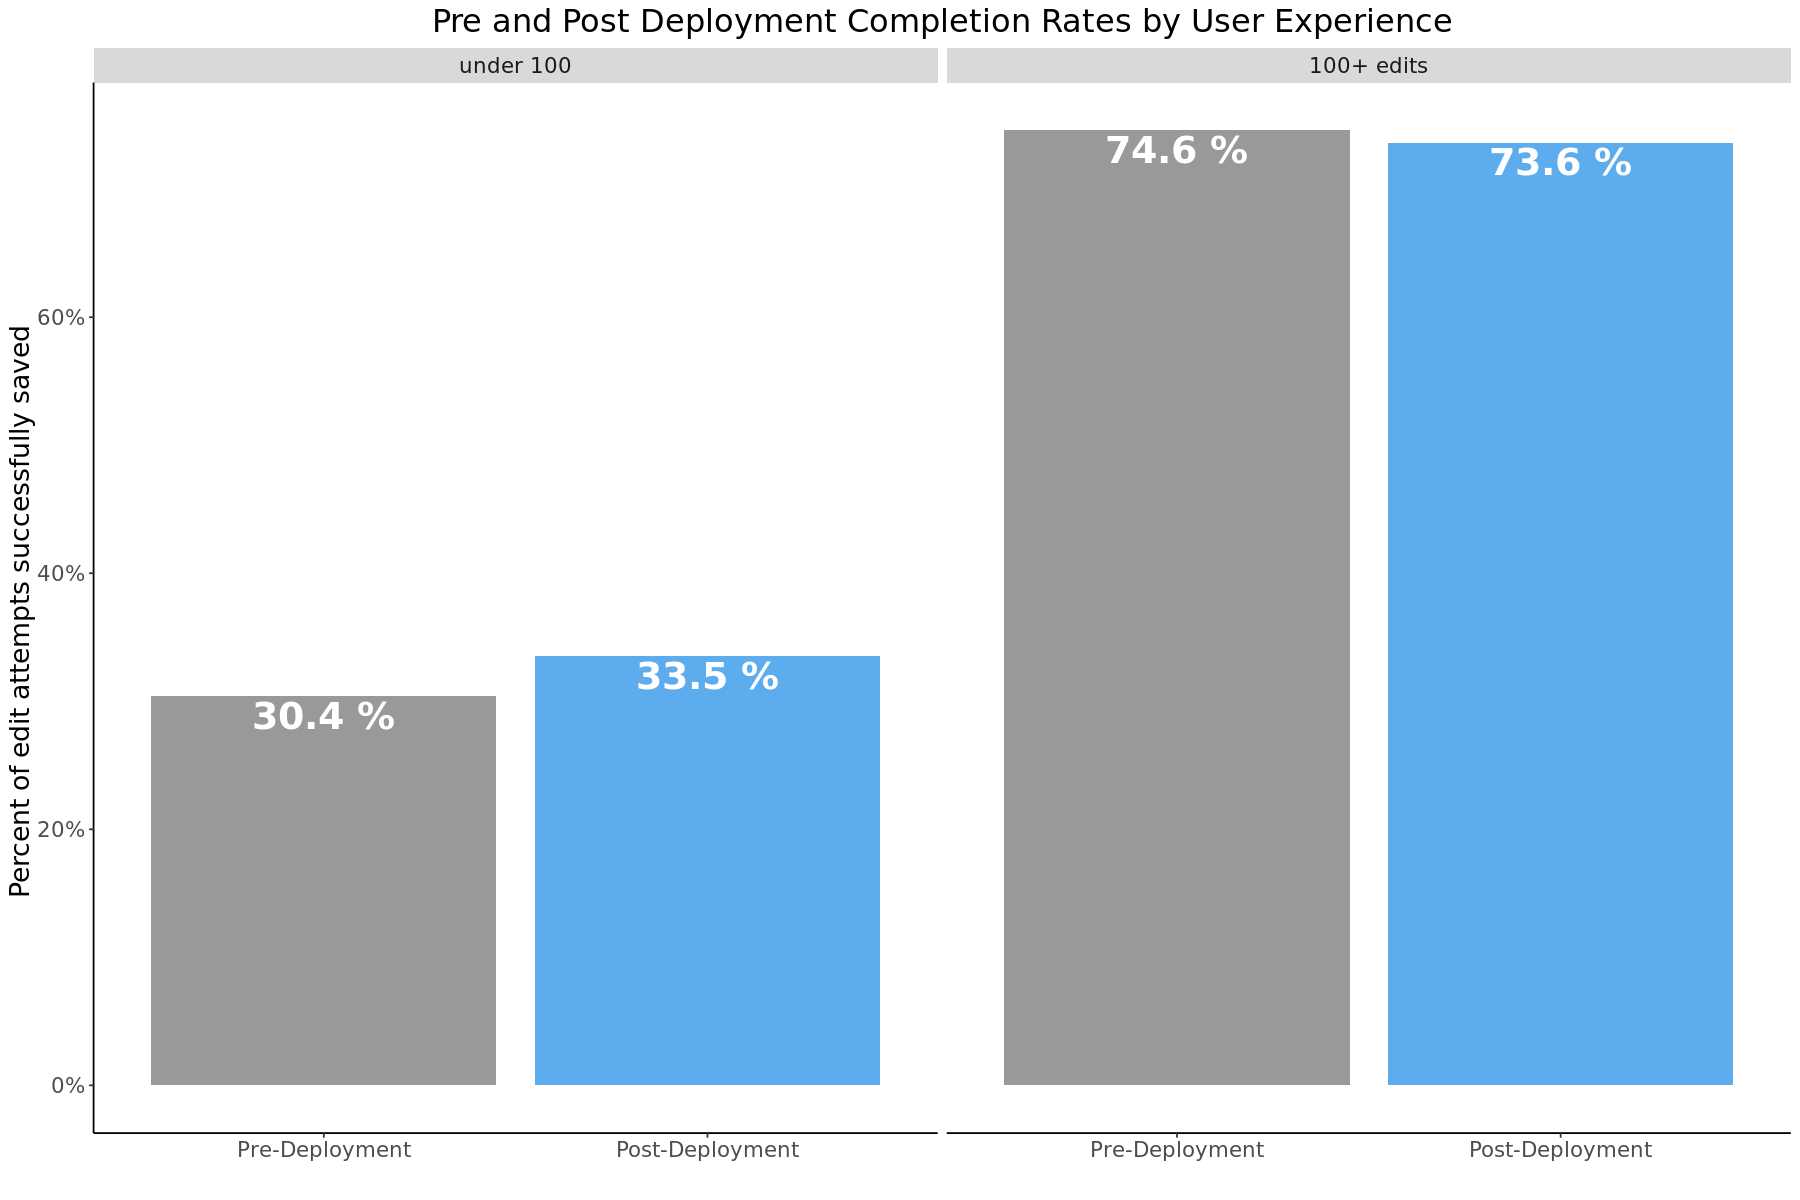

In [313]:
p <- completion_rate_pre_post_byexp  %>%
    ggplot(aes(x= pre_post, y = completion_rate, fill = pre_post)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(completion_rate * 100, "%"), fontface=2), vjust=1.2, size = 8, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    scale_x_discrete(labels = c("Pre-Deployment", "Post-Deployment")) +
    facet_wrap(~experience_level) +
    labs (y = "Percent of edit attempts successfully saved ",
          x = "",
          title = "Pre and Post Deployment Completion Rates by User Experience")  +
    scale_fill_manual(values= c("#999999", "steelblue2")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/completion_rate_pre_post_byexp.png", p, width = 16, height = 8, units = "in", dpi = 300)

There was a +10.2% increase in talk page edit completion rate for Junior editors and only a slight decrease (-1.3%) in edit completion rate for senior editors

## By Logged In Status

In [314]:
completion_rate_pre_post_bystatus <-  completion_rate_pre_post_table %>%
    group_by(pre_post, user_status) %>%
    summarise(n_attempts = sum(n_attempts),
              n_saves = sum(n_saves),
              completion_rate = round(n_saves/n_attempts, 3))

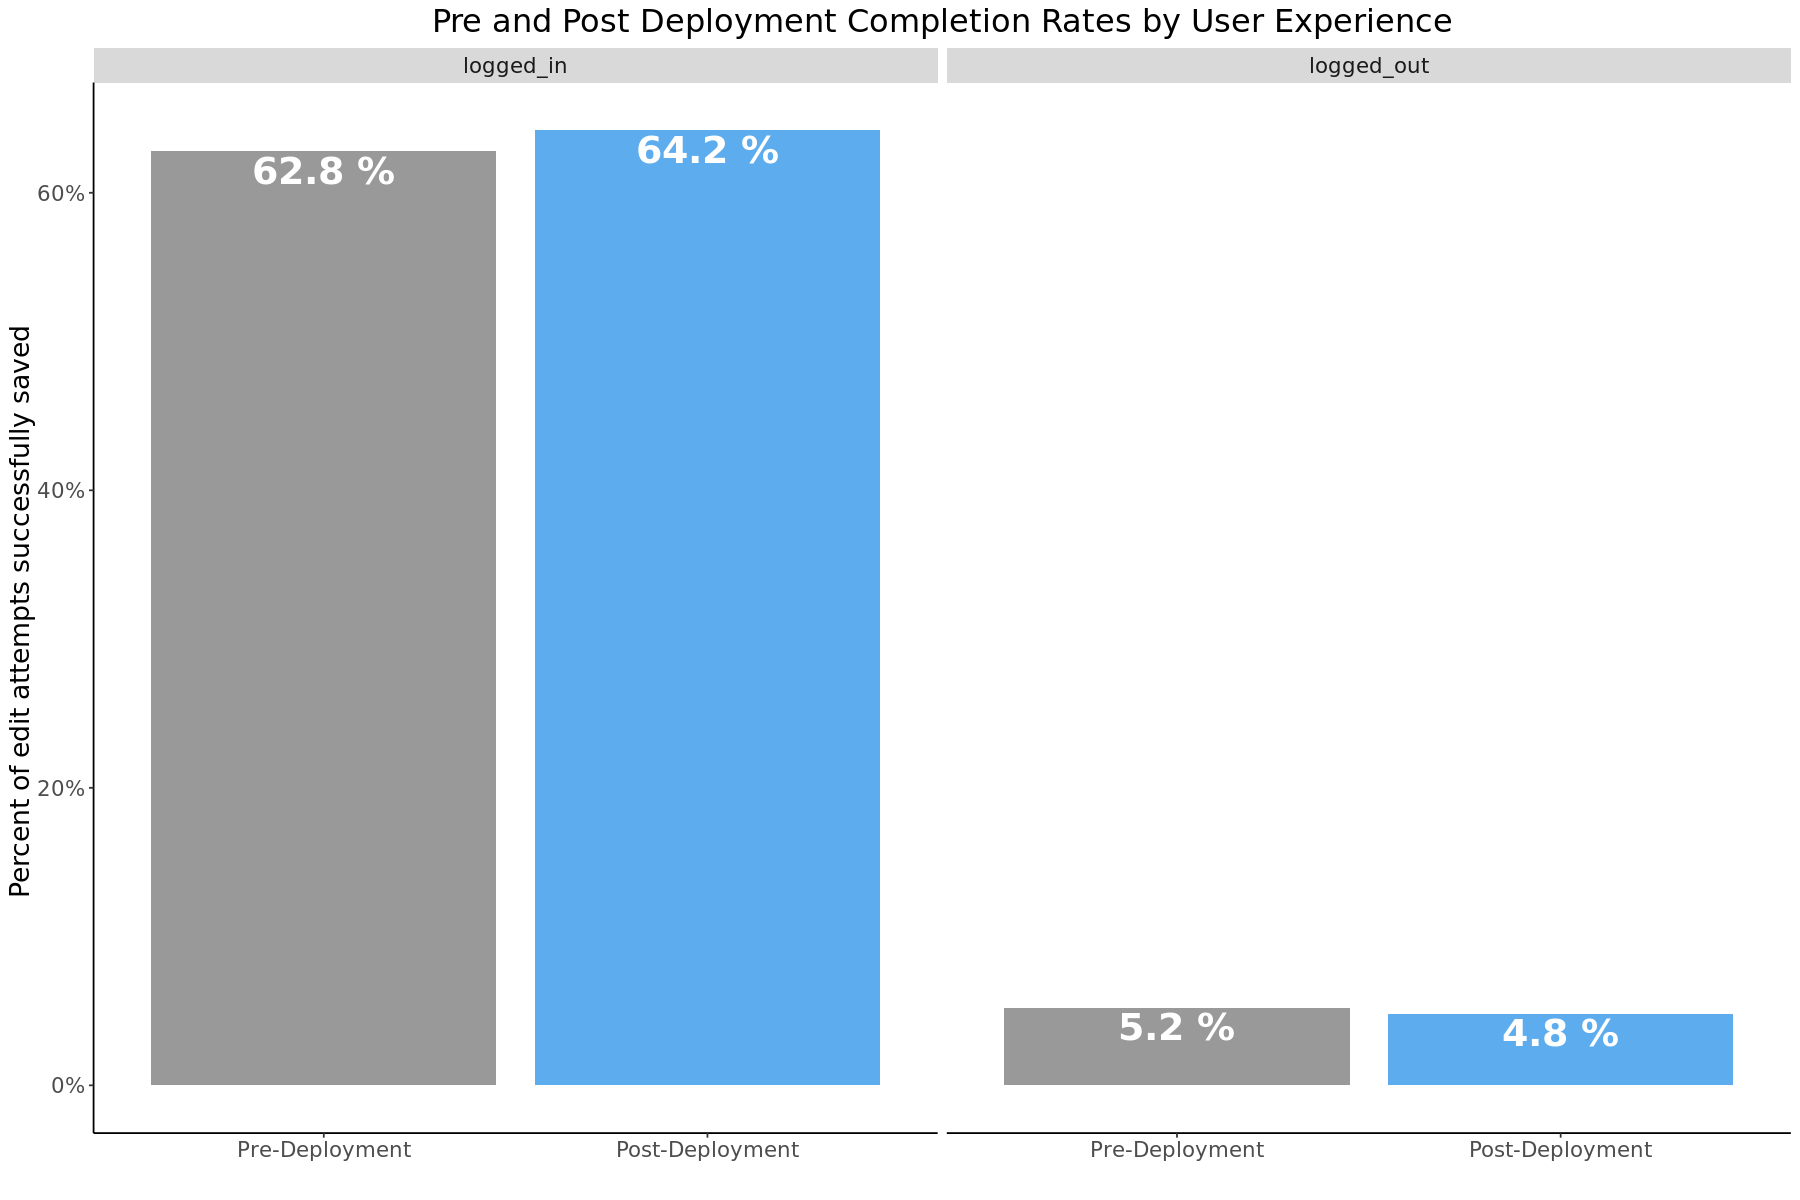

In [315]:
p <- completion_rate_pre_post_bystatus   %>%
    ggplot(aes(x= pre_post, y = completion_rate, fill = pre_post)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(completion_rate * 100, "%"), fontface=2), vjust=1.2, size = 8, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    scale_x_discrete(labels = c("Pre-Deployment", "Post-Deployment")) +
    facet_wrap(~user_status) +
    labs (y = "Percent of edit attempts successfully saved ",
          x = "",
          title = "Pre and Post Deployment Completion Rates by User Experience")  +
    scale_fill_manual(values= c("#999999", "steelblue2")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/completion_rate_pre_post_bystatus.png", p, width = 16, height = 8, units = "in", dpi = 300)

# User Block Rate


We also reviewed the number of users blocked after publishing a talk page edit.

Data comes from the [mediawiki_user_history](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Edits/Mediawiki_user_history) table. All block events were identified in the data by `caused_by_event_type = "alterblocks"`. The data includes any Contributors that were blocked after posting a comment; however, we do not know if they were blocked specifically due to the comment posted. 


In [332]:
block_user_data <-
  read.csv(
    file = 'Data/block_data.csv',
    header = TRUE,
    sep = ",",
    stringsAsFactors = FALSE
  ) # loads all block data 

In [333]:
#reformat and clean data
block_user_data$date <- as.Date(block_user_data$date, format = "%Y-%m-%d")

#clarfiy wiki names
block_user_data <- block_user_data %>%
  mutate(
    wiki = case_when(
      #clarfiy participating project names
     wiki == 'cswiki' ~ "Czech Wikipedia",
      wiki == 'huwiki' ~ "Hungarian Wikipedia",
      wiki == 'arwiki' ~ "Arabic Wikipedia",  
    ) )


# group user edit count 
block_user_data <- block_user_data %>%
 mutate(
    experience_level = case_when(
       experience_level  < 100  ~ "under 100",
      experience_level  >= 100 ~ '100+ edits'  
    )
  ) 

# add factor levels to exp level
block_user_data$experience_level <-
  factor(block_user_data$ experience_level,
         levels = c("under 100", "100+ edits"))

## Daily Blocks

Note: This is based on the time of the block.

In [334]:
block_rate_daily <- block_user_data %>%
    group_by(wiki, date) %>%
  summarise(n_blocks = sum(blocked_user),
            n_users = sum(all_users),
           block_rate = n_blocks/n_users)

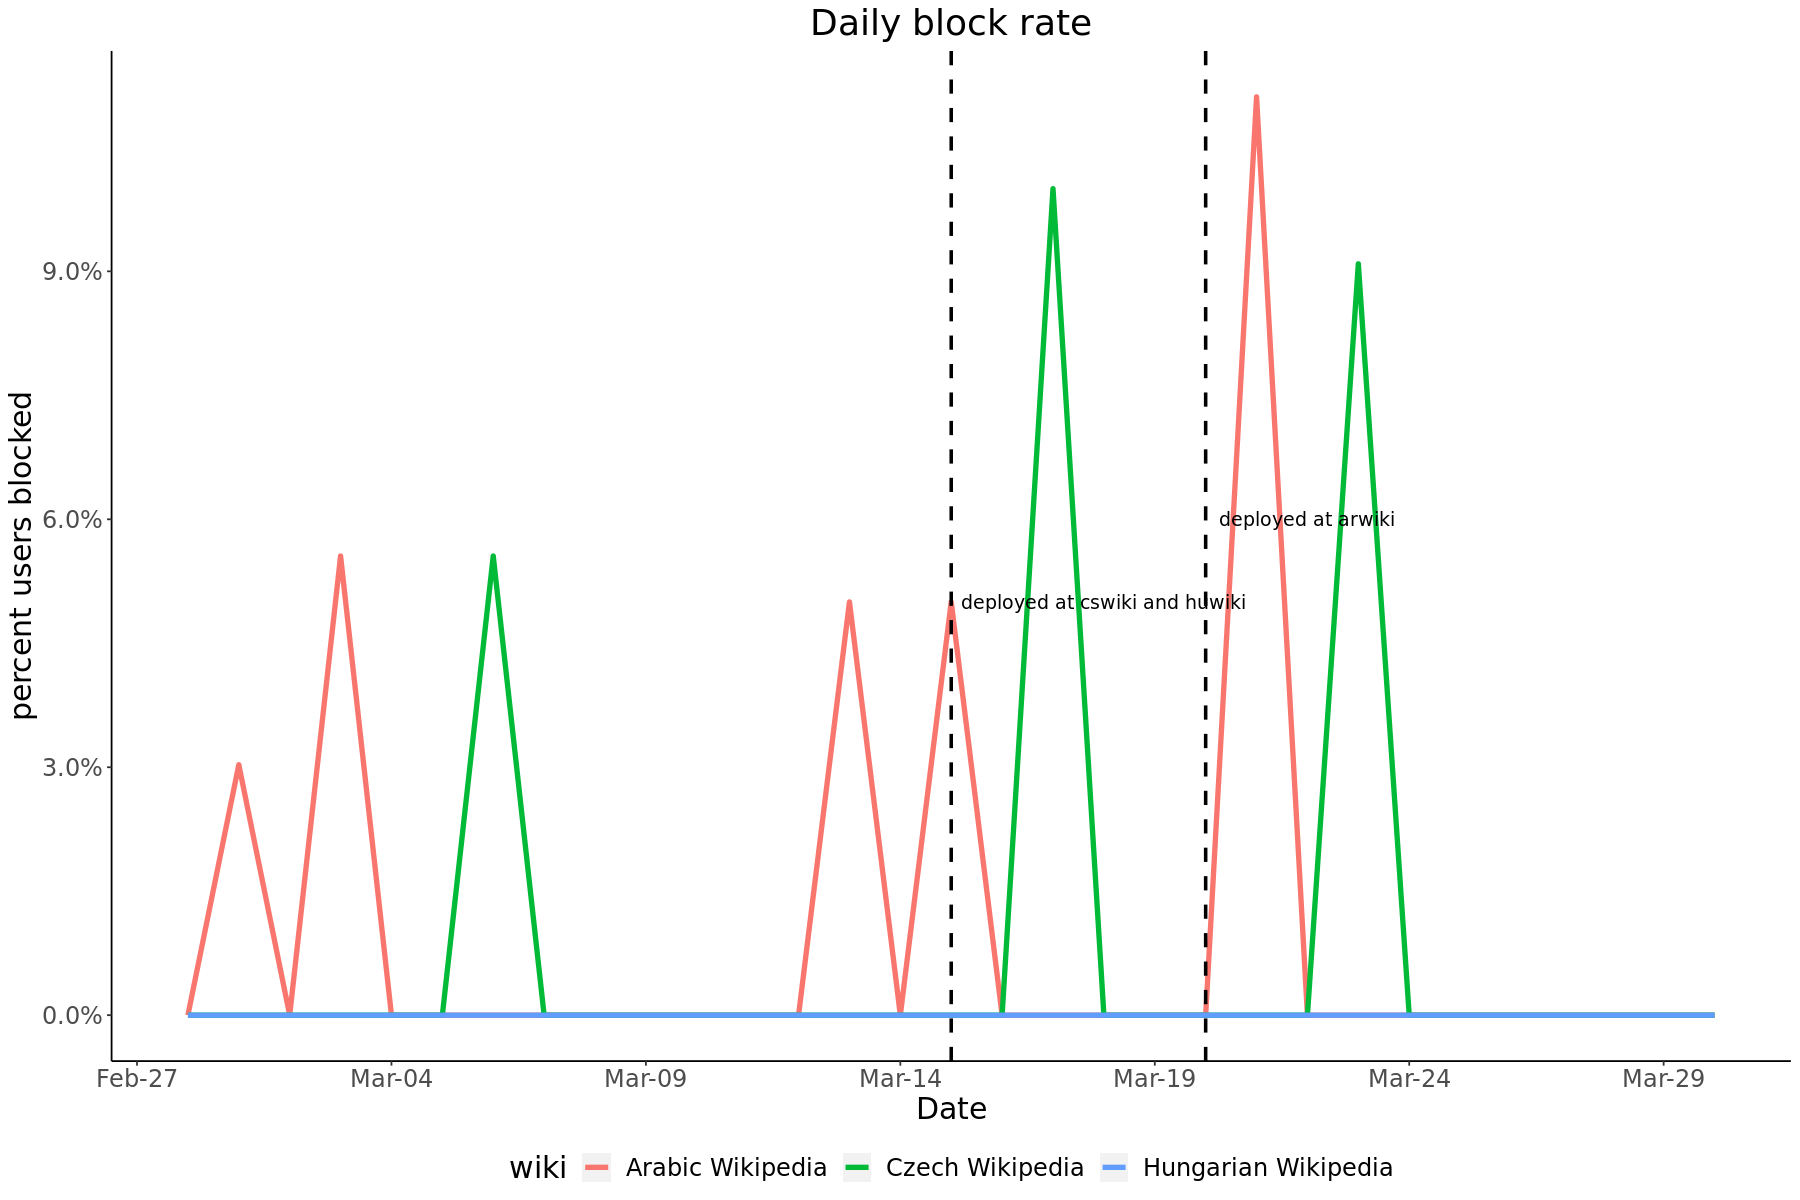

In [224]:
# plot daily session length before and after deployment of English Wikipedia

textaes <- data.frame(y = c(0.05, 0.06),
                      x = as.Date(c('2023-03-18','2023-03-22')),
                      lab = c('deployed at cswiki and huwiki', 'deployed at arwiki' ))

p <- block_rate_daily  %>%
    ggplot(aes(x= date, y = block_rate, color = wiki)) +    
    geom_line(size =1.5) +
    geom_vline(xintercept = as.Date(c('2023-03-15','2023-03-20')), linetype = 'dashed', size = 1) +
     geom_text(mapping = aes(y = y, x = x, label = lab), 
            data = textaes, inherit.aes = FALSE, size = 4) +
    scale_y_continuous(labels = scales::percent) +
    scale_x_date("Date", date_breaks = "5 days", date_labels = "%b-%d") +
  labs(title = "Daily block rate",
      y = "percent users blocked",
      x= "Date") +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 

p

ggsave("Figures/block_rate_daily.png", p, width = 16, height = 8, units = "in", dpi = 300) 

There are only a few users blocked per day so this data is susceptible to large percent changes and fluctuations. 

## Two Weeks Pre and Post Deployment Analysis

In [335]:
# block rate at cswiki and huwiki 
block_rate_pre_post_cshu <- block_user_data %>%
    filter(wiki != 'Arabic Wikipedia') %>%
    filter(date >= '2023-02-28' & date <= '2023-03-29') %>% # two weeks before and after
    mutate(pre_post = ifelse(date < '2023-03-15', 'pre', 'post')) %>%
    group_by (wiki, experience_level, pre_post)  %>%
     summarise(n_blocks = sum(blocked_user),
            n_users = sum(all_users),
           block_rate = n_blocks/n_users)

In [336]:
# block rate at arwiki
block_rate_pre_post_arwiki <- block_user_data %>%
    filter(wiki == 'Arabic Wikipedia') %>%
    filter(date >= '2023-03-05' & date <= '2023-03-31') %>% # two weeks before and after
    mutate(pre_post = ifelse(date < '2023-03-20', 'pre', 'post')) %>%
    group_by (wiki, experience_level, pre_post)   %>%
     summarise(n_blocks = sum(blocked_user),
            n_users = sum(all_users),
           block_rate = n_blocks/n_users)

In [337]:
# Join two dfs
block_rate_pre_post_table <- rbind(block_rate_pre_post_cshu, block_rate_pre_post_arwiki ) %>%
        mutate(pre_post = factor(
    pre_post,
    levels = c('pre', 'post'),
    labels = c("Pre-Deployment", "Post-Deployment"))
  )


In [338]:
block_rate_pre_post_bywiki  <- block_rate_pre_post_table %>%
    group_by(wiki, pre_post) %>%
    summarise(n_blocks = sum(n_blocks),
              n_users = sum(n_users),
              block_rate = round(n_blocks/n_users, 3))


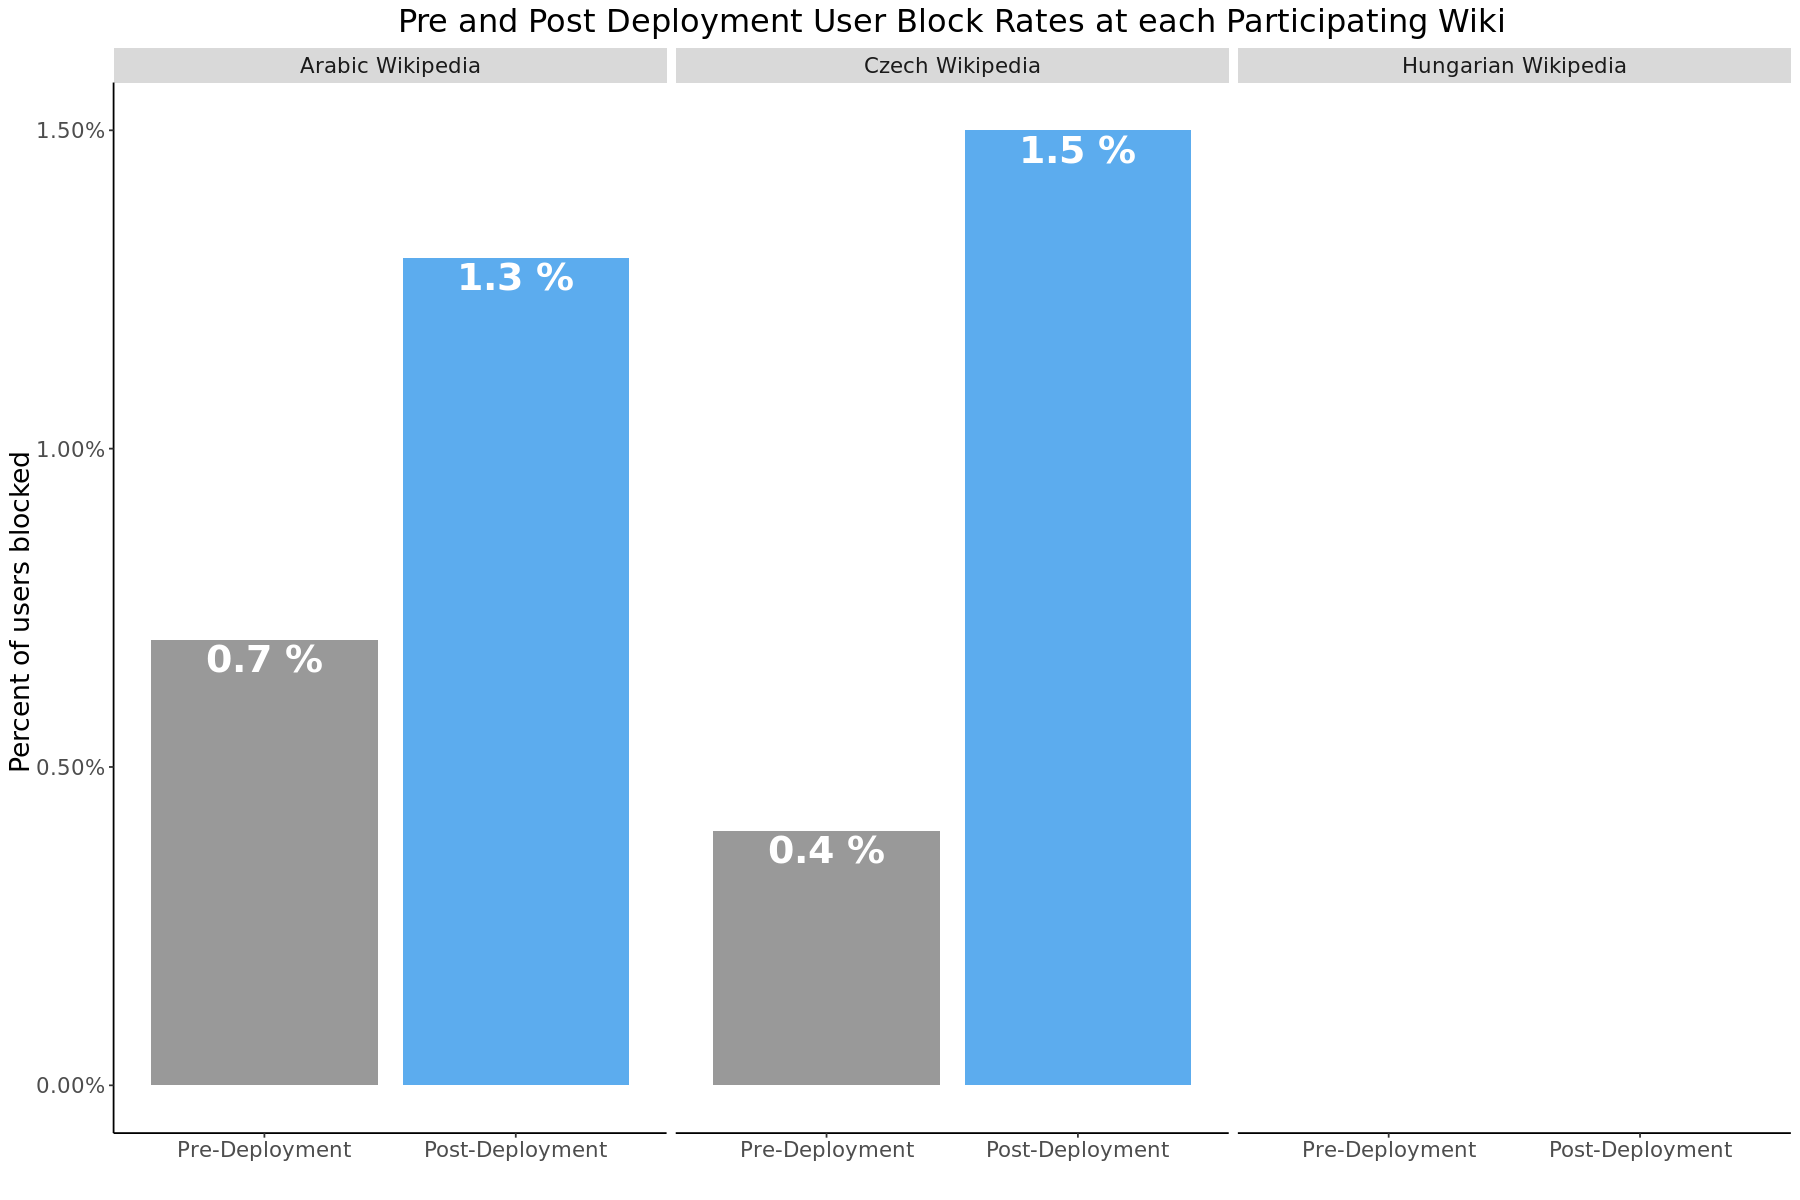

In [339]:
p <- block_rate_pre_post_bywiki  %>%
    ggplot(aes(x= pre_post, y = block_rate, fill = pre_post)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(block_rate * 100, "%"), fontface=2), vjust=1.2, size = 8, color = "white") +
    scale_y_continuous(labels = scales::percent) +
    scale_x_discrete(labels = c("Pre-Deployment", "Post-Deployment")) +
    facet_wrap(~wiki) +
    labs (y = "Percent of users blocked ",
          x = "",
          title = "Pre and Post Deployment User Block Rates at each Participating Wiki")  +
    scale_fill_manual(values= c("#999999", "steelblue2")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/block_rate_pre_post_bywiki.png", p, width = 16, height = 8, units = "in", dpi = 300)

No user blocks at Hungarian Wikipedia. We did observe an increase in the block rate at Arabic and Czech Wikipedia, comparing two weeks pre and post deployment but the absolute number of blocks did not change.

## Overall

In [ ]:
block_rate_pre_post_overall  <- block_rate_pre_post_table %>%
    group_by(pre_post) %>%
    summarise(n_blocks = sum(n_blocks),
              n_users = sum(n_users),
              block_rate = round(n_blocks/n_users, 3))


 Less than 1.5% of users were blocked pre and post deployment. 

## By Experience Level

In [341]:
block_rate_pre_post_byexp  <- block_rate_pre_post_table %>%
    group_by(experience_level, pre_post) %>%
    summarise(n_blocks = sum(n_blocks),
              n_users = sum(n_users),
              block_rate = round(n_blocks/n_users, 3))



# Opt Out Rate

The usability improvements preference ('discussiontools-visualenhancements') was enabled by default for all users on these three partner wikis; however, it could be disabled in their preference setting.

I reviewed the mediawiki [user_properties table](https://www.mediawiki.org/wiki/Manual:User_properties_table) to determine the number of users that made a talk page edit attempt on these wikis since it was enabled by defauly and currently have the preference disabled. 

Some notes regarding this dataset:
* This reflects all current nondefault user preferences.  User property records are added to the database when they differ from their default value.
* Data reflects the current state and does not account for users that have changed this preference multiple times.
* Some users may have disabled the setting by selecting 'restore all default preferences' in their user preferences or disabled all discussion tool preferences by opting out of the discussion tool beta preference.
* Data collection and analysis can be found under Queries/opt_out_rate.pynb


**Findings:**
* There are a total of 48 users across all three wikis that have turned the feature off. 39 of those users from arwiki.
* Less than 1% of the total number of users who made a desktop talk page edit attempt following the deployment of the usability improvements (2,122 people) disabled the feature during the reviewed time period.